# Medical insurance prediction

**Goal:** Predict the insurance costs using all available features. 

Credits: Data freely available from https://github.com/stedy/Machine-Learning-with-R-datasets

Let's load the dataset and the needed libraries

In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# if 'google.colab' in str(get_ipython()):
#   from google_drive_downloader import GoogleDriveDownloader as gdd
#   gdd.download_file_from_google_drive(file_id='1xhM2x8WoIk3JicauwfQrhKmC1_kZ6KzX',
#   dest_path='./insurance.csv')
# else:
#   print('Please put the file insurance.csv in the same folder as the notebook')

In [3]:
data_original = pd.read_csv('./insurance.csv')

Let's look at the data

In [4]:
data_original.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


So we have seven features:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: yes or no
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance. That's what we want to predict !

Remember that our goal is to predict the `charges` using all the other features. So `charges` represents our vector of `y `and all other features our matrix `X`

*Question*: Is it a regression or a classification problem ?

**Answer**  
C'est un problème de régression.

The first thing to do is to look if there are `Nan`values, namely errors or missing values.

In [5]:
data_original.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Good news ! No `Nan` values

Now let's have a look at the distribution of the different features

Text(0.5, 1.0, 'charges')

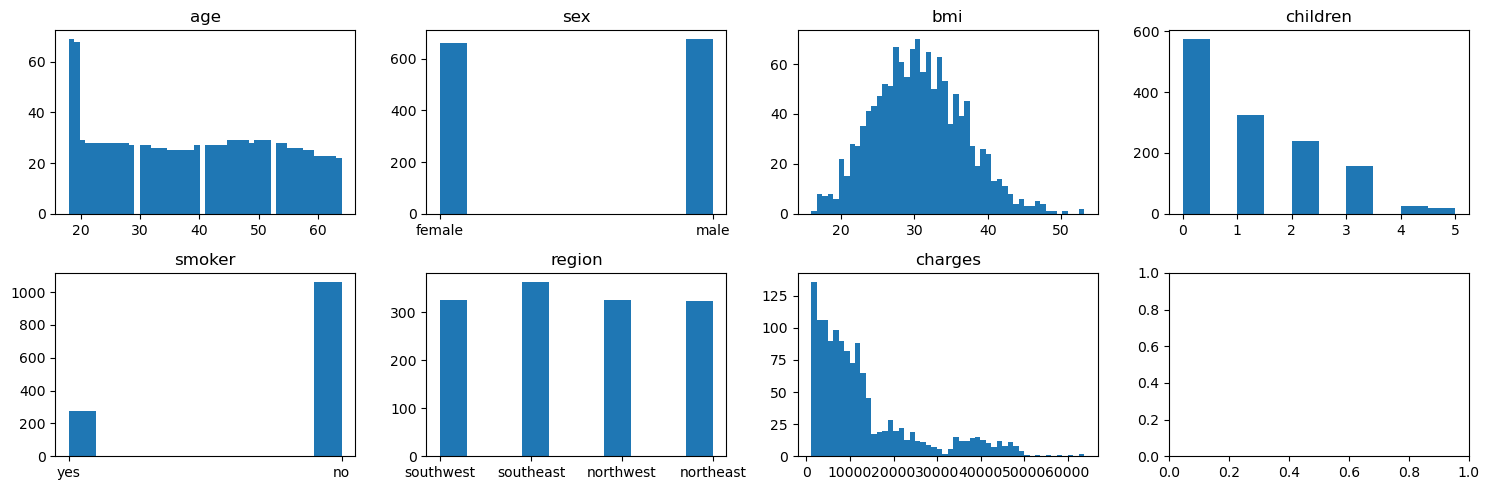

In [6]:
n_bins = 20
fig, axs = plt.subplots(2, 4, sharey=False, tight_layout=True, figsize=(15, 5))

axs[0, 0].hist(data_original.age,bins=50)
axs[0, 0].set_title('age')
axs[0, 1].hist(data_original.sex)
axs[0, 1].set_title('sex')
axs[0, 2].hist(data_original.bmi,bins=50)
axs[0, 2].set_title('bmi')
axs[0, 3].hist(data_original.children)
axs[0, 3].set_title('children')
axs[1, 0].hist(data_original.smoker)
axs[1, 0].set_title('smoker')
axs[1, 1].hist(data_original.region)
axs[1, 1].set_title('region')
axs[1, 2].hist(data_original.charges,bins=50)
axs[1, 2].set_title('charges')

We can already notice that:
- distribution of age is quite uniform
- male and female are balanced
- bmi looks like a Gaussian distribution (good for stats)
- There are definitely more people without children or with only one
- There are definitely more people who don't smoke
- regions are balanced
- charges is a right skewed distribution -> we can use a log to make it normal ! Easy to use in practice, many models and statistical test make the normal distribtion hypothesis

It seems that we have both numerical and categorical features. Let's check that !

In [7]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


OK. we have 3 categorical variables. Let's convert them

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

data = data_original.copy()

# Sex
data.sex[data.sex=='female']=0
data.sex[data.sex=='male']=1
data.sex = data.sex.astype(str).astype(int)

# same as
#le = LabelEncoder()
#data.sex = le.fit_transform(data.sex)

# Smoker
# here it's better to do it by hand to be sure that 'no' is 0 and 'yes' is 1
data.smoker[data.smoker=='no']=0
data.smoker[data.smoker=='yes']=1
data.smoker = data.smoker.astype(str).astype(int)

# Region
enc = OneHotEncoder(sparse=False) # better not to use sparse matrix here (more interpretable)
cat_regions = data.region.unique() # list of regions
# OneHotEncoder needs a 2D array, so we need to transform it in a column vector 
# and in order to do that we need to have a numpy array, thus the .values
region = enc.fit_transform(data.region.values.reshape(-1, 1))

# region is now a numpy array, needs to transofmr in a panda frame
region_df = pd.DataFrame(region, columns=cat_regions)

# we can now drop the column with the old 'region' feature ...
data.drop('region',inplace=True, axis=1)

# ... and add the new binary variables resulting from OneHotEncoder
dataOHE = pd.concat([data, region_df], axis=1)


Let's have a look at the new DataFrame

In [9]:
dataOHE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int32  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int32  
 5   charges    1338 non-null   float64
 6   southwest  1338 non-null   float64
 7   southeast  1338 non-null   float64
 8   northwest  1338 non-null   float64
 9   northeast  1338 non-null   float64
dtypes: float64(6), int32(2), int64(2)
memory usage: 94.2 KB


OK. All variables are numerical. We can now start the analysis. It's always good to start by checking the correlations between the variables

<AxesSubplot: >

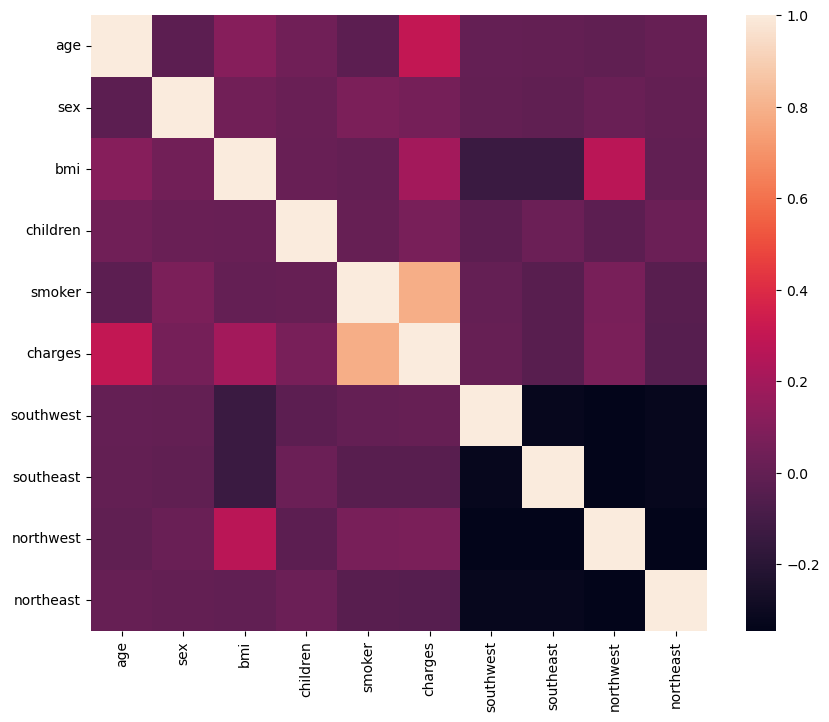

In [10]:
f, ax = plt.subplots(figsize=(10, 8))
corr = dataOHE.corr()
sns.heatmap(corr,square=True,ax=ax)

We can see that:
- bmi seem to be a bit correlated with the nortwest region and with charges
- all the other high correlations concern `charges`

To see possible (direct) colinearities among features the scatter plot is also a good tool

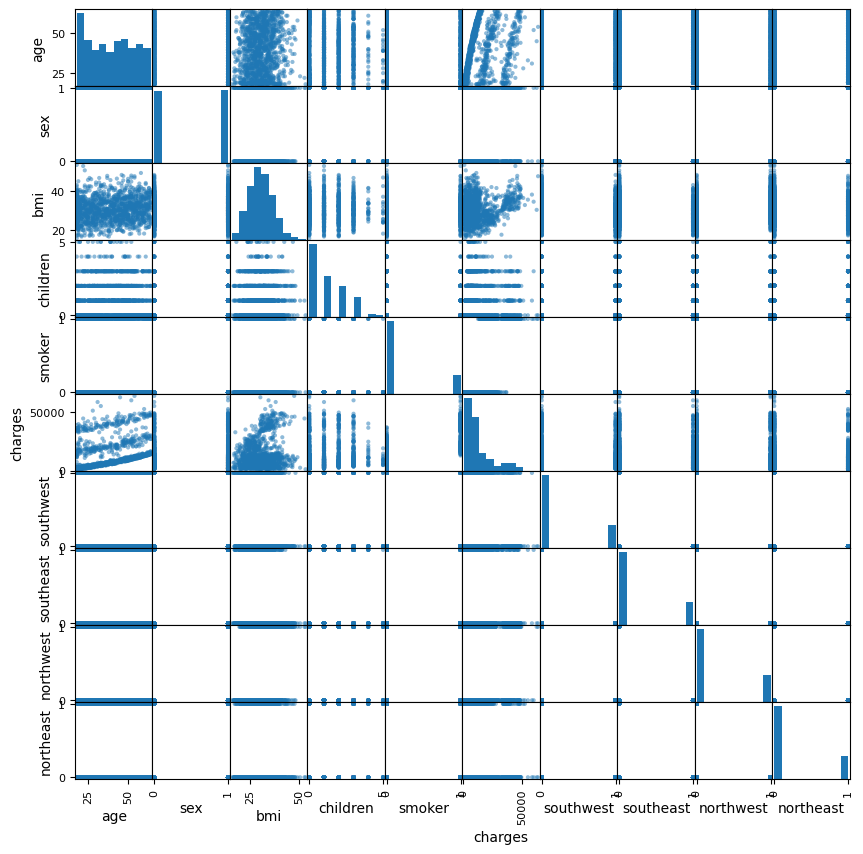

In [11]:
axeslist = pd.plotting.scatter_matrix(dataOHE, diagonal='hist', figsize=(10,10))

We can see that there is a clear pattern, like three different cluster, between age and charges. Let's have a closer look

Text(0.5, 0, 'age')

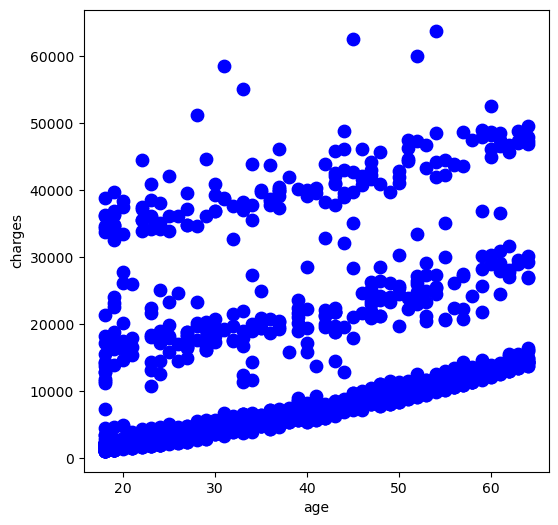

In [12]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.scatter(dataOHE.age, dataOHE.charges, c='b',s=80, marker='o')
plt.ylabel('charges')
plt.xlabel('age')

We'll come back to that later.
Now let's have a closer look to the correlations of `charges`

In [13]:
dataOHE.corr()['charges'].sort_values()

northeast   -0.043210
southeast   -0.039905
southwest    0.006349
sex          0.057292
children     0.067998
northwest    0.073982
bmi          0.198341
age          0.299008
smoker       0.787251
charges      1.000000
Name: charges, dtype: float64

Well, guess what... it seems that if you smoke, your charges are higher. 
What happens if we change the distribution of charges using the log function ?

In [14]:
charge_dist = dataOHE["charges"].values
logcharge = np.log(dataOHE["charges"].values)

Text(0.5, 1.0, 'ln(charges)')

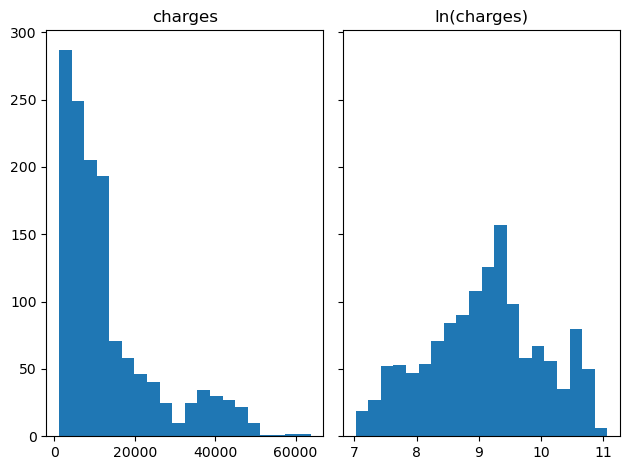

In [15]:
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(charge_dist, bins=n_bins)
axs[0].set_title('charges')
axs[1].hist(logcharge, bins=n_bins)
axs[1].set_title('ln(charges)')

In [16]:
dataOHE.charges=np.log(dataOHE.charges)
dataOHE.corr()['charges'].sort_values()

northeast   -0.041632
southeast   -0.017824
sex          0.005632
northwest    0.015791
southwest    0.043115
bmi          0.132669
children     0.161336
age          0.527834
smoker       0.665506
charges      1.000000
Name: charges, dtype: float64

Well, now it seems that charges is also correalated a bit with the age, which is quite expected I would say

Let's look at the distribution of charges for smokers and non smokers

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

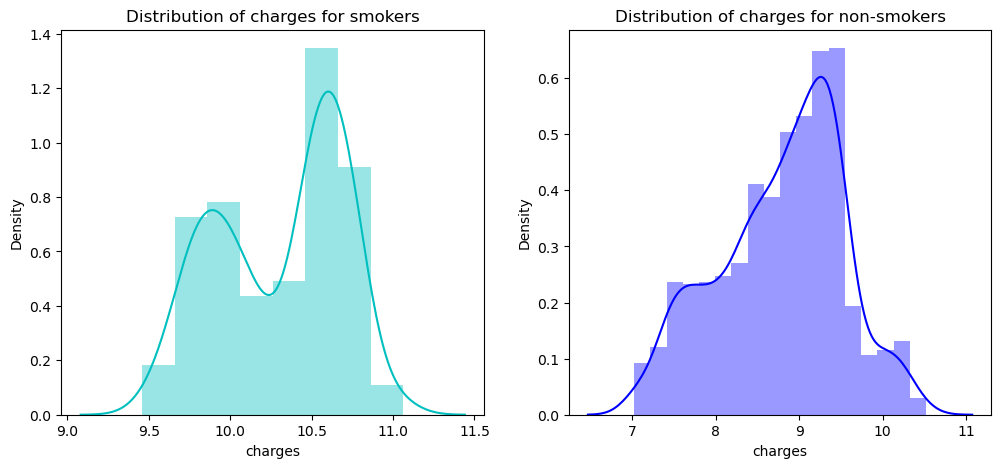

In [17]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(dataOHE[(dataOHE.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(dataOHE[(dataOHE.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

We can see that non-smokers pay less but let's look if we also condition on the age

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

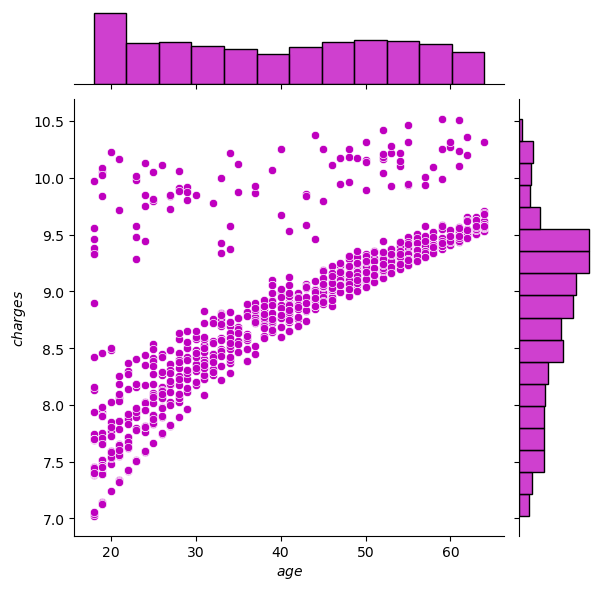

In [18]:
g = sns.jointplot(x='age', y='charges',data=dataOHE[dataOHE.smoker==0], color="m")
g.set_axis_labels("$age$", "$charges$")
ax.set_title('Distribution of charges and age for non-smokers')

Well, it seems that for non-smokers charges increase with age. Quite expected !
Let's look now at smokers...

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

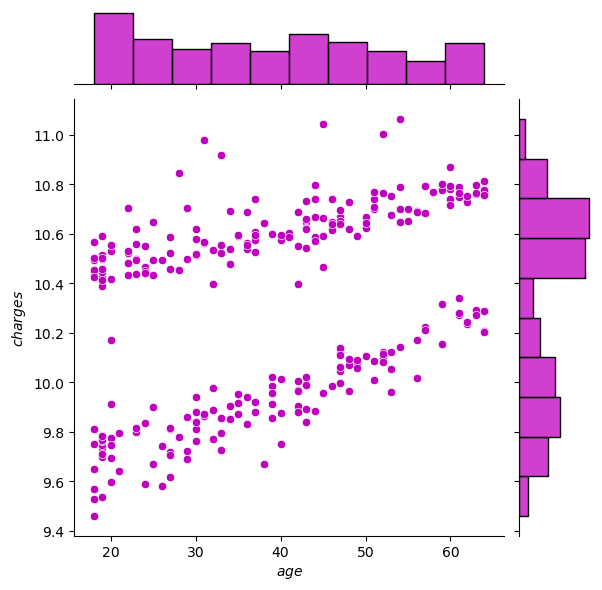

In [19]:
g = sns.jointplot(x='age', y='charges',data=dataOHE[(dataOHE.smoker==1)], color="m")
g.set_axis_labels("$age$", "$charges$")
ax.set_title('Distribution of charges and age for smokers')

We can see that there are clearly two trends... might it be the sex ? Let's have a look

Text(0.5, 1.0, 'Distribution of charges and age for female smokers')

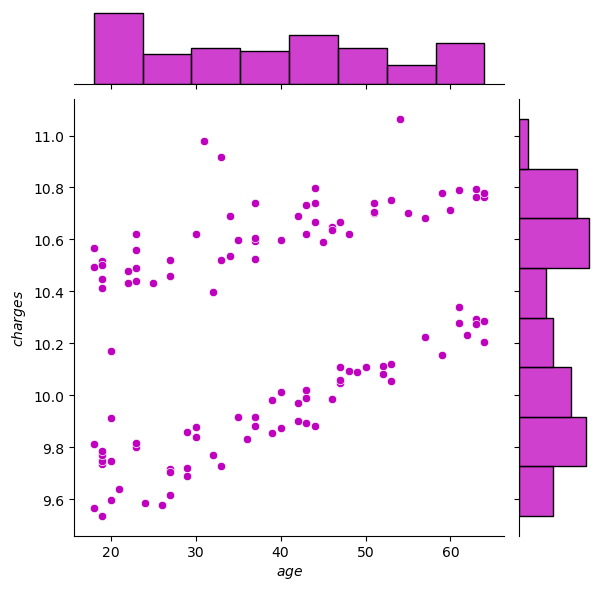

In [20]:
g = sns.jointplot(x='age', y='charges',data=dataOHE[(dataOHE.smoker==1) & (dataOHE.sex==0)], color="m")
g.set_axis_labels("$age$", "$charges$")
ax.set_title('Distribution of charges and age for female smokers')

Nope, wrong hypothesis... let's try with bmi.

Text(0.5, 0, 'age')

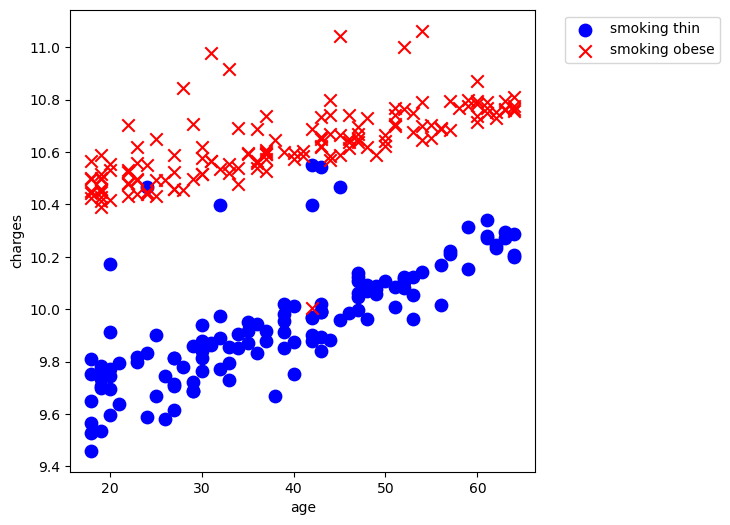

In [21]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()

plt.scatter(dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi<30)].age, dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi<30)].charges,
                c='b',s=80, marker='o',label='smoking thin')
plt.scatter(dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi>=30)].age, dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi>=30)].charges,
                c='r',s=80, marker='x',label='smoking obese')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('charges')
plt.xlabel('age')

Bingo ! We can clearly see that, among smoker, obese people pay more than thin people regardless the age

And what if we also consider the non-smoking ones ?

Text(0.5, 0, 'age')

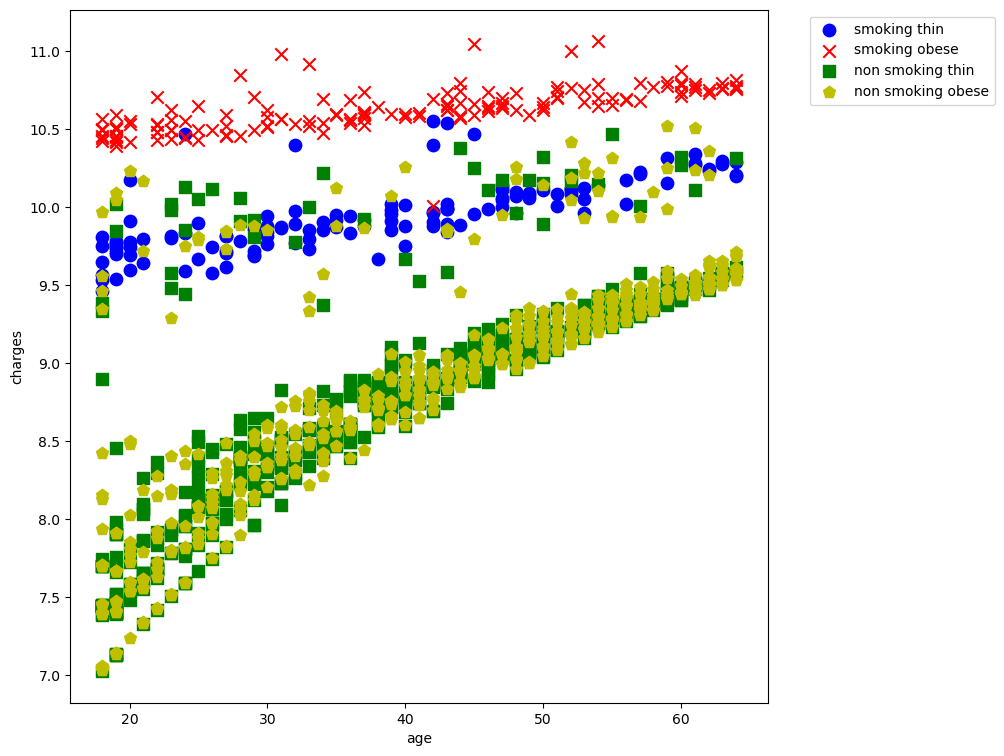

In [22]:
fig1 = plt.figure(figsize=(9, 9))
ax = plt.gca()

plt.scatter(dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi<30)].age, dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi<30)].charges,
                c='b',s=80, marker='o',label='smoking thin')
plt.scatter(dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi>=30)].age, dataOHE[(dataOHE.smoker==1) & (dataOHE.bmi>=30)].charges,
                c='r',s=80, marker='x',label='smoking obese')
plt.scatter(dataOHE[(dataOHE.smoker==0) & (dataOHE.bmi<30)].age, dataOHE[(dataOHE.smoker==0) & (dataOHE.bmi<30)].charges,
                c='g',s=80, marker='s',label='non smoking thin')
plt.scatter(dataOHE[(dataOHE.smoker==0) & (dataOHE.bmi>=30)].age, dataOHE[(dataOHE.smoker==0) & (dataOHE.bmi>=30)].charges,
                c='y',s=80, marker='p',label='non smoking obese')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('charges')
plt.xlabel('age')

This was not expected ! It seems that if you do not smoke your charges will not change if you are obese or not. Glad to hear it (I am a non smoker..)

### ***Prediction***

Now it's time to predict the charges using the methods seen during the lectures

Let's first create our matrix of features `X`and target vector `y`

In [23]:
y = dataOHE.charges
X = dataOHE.drop(['charges'], axis = 1)
name_features=X.columns
print(X)

      age  sex     bmi  children  smoker  southwest  southeast  northwest  \
0      19    0  27.900         0       1        0.0        0.0        0.0   
1      18    1  33.770         1       0        0.0        0.0        1.0   
2      28    1  33.000         3       0        0.0        0.0        1.0   
3      33    1  22.705         0       0        0.0        1.0        0.0   
4      32    1  28.880         0       0        0.0        1.0        0.0   
...   ...  ...     ...       ...     ...        ...        ...        ...   
1333   50    1  30.970         3       0        0.0        1.0        0.0   
1334   18    0  31.920         0       0        1.0        0.0        0.0   
1335   18    0  36.850         0       0        0.0        0.0        1.0   
1336   21    0  25.800         0       0        0.0        0.0        0.0   
1337   61    0  29.070         0       1        0.0        1.0        0.0   

      northeast  
0           1.0  
1           0.0  
2           0.0  
3  

We can see that the features `age` and `bmi` have different ranges with respect to the other variables and need to be scaled

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

n_features = X_train.shape[1]
n_samples = X_train.shape[0]

print('Number training samples ', n_samples, ' and number features', n_features)

scaler = StandardScaler()
scaler.fit(X_train[['age','bmi']])
X_train[['age','bmi']] = scaler.transform(X_train[['age','bmi']])
X_test[['age','bmi']] = scaler.transform(X_test[['age','bmi']])

# remember to always scale on the train and apply the same scaling factor to the test
# you should never use the test set before prediction


Number training samples  1003  and number features 9


Let's try to use the three linear methods seen in the lecture: linear, Ridge and Lasso.

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# data are already centred and normalized
linear = LinearRegression(normalize=False,fit_intercept=False)
linear.fit(X_train, y_train)
print('Training score: ',linear.score(X_train, y_train), '; Test score: ', linear.score(X_test, y_test))

ridge = Ridge(normalize=False,fit_intercept=False)
ridge.fit(X_train, y_train)
print(ridge.score(X_test, y_test))

lasso = Lasso(alpha=1e-3, normalize=False,fit_intercept=False)
lasso.fit(X_train, y_train)
print(lasso.score(X_test, y_test))


Training score:  0.764220434496766 ; Test score:  0.7782429592887121
0.7767007673461832
0.7783610385098735


It seems that results are not so different. We could use the function `enet_path` to check how parameter weights are changing when using a L2-norm regularization (Ridge) or a L1-norm (Lasso) or both (E-net).

In [26]:
from sklearn.linear_model import enet_path

def enet_plot(l1_ratio,X_train,y_train,lambda_lasso,name_features):
    """Function plotting enet_path for some tuning parameter."""
    plt.rcParams['mathtext.fontset'] = 'cm'
    _, beta_enet, _ = enet_path(X_train, y_train, alphas=lambda_lasso, l1_ratio=l1_ratio)
    fig1 = plt.figure(figsize=(15, 5))
    ax1 = fig1.add_subplot(111)
    ax1.plot(lambda_lasso, np.transpose(beta_enet), linewidth=3)
    plt.title("Enet path: " + r"$p={0}, n={1}, \gamma={2}$".format(n_features,
                                                        n_samples, l1_ratio), fontsize=16)

    plt.legend(name_features,bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_xscale('log')
    ax1.set_xlabel(r"$\lambda$")
    ax1.set_ylabel("Coefficient value")
    
    return beta_enet



In [27]:
#range of lambda values
lambda_lasso = np.logspace(np.log10(100), np.log10(1e-2), num=100)

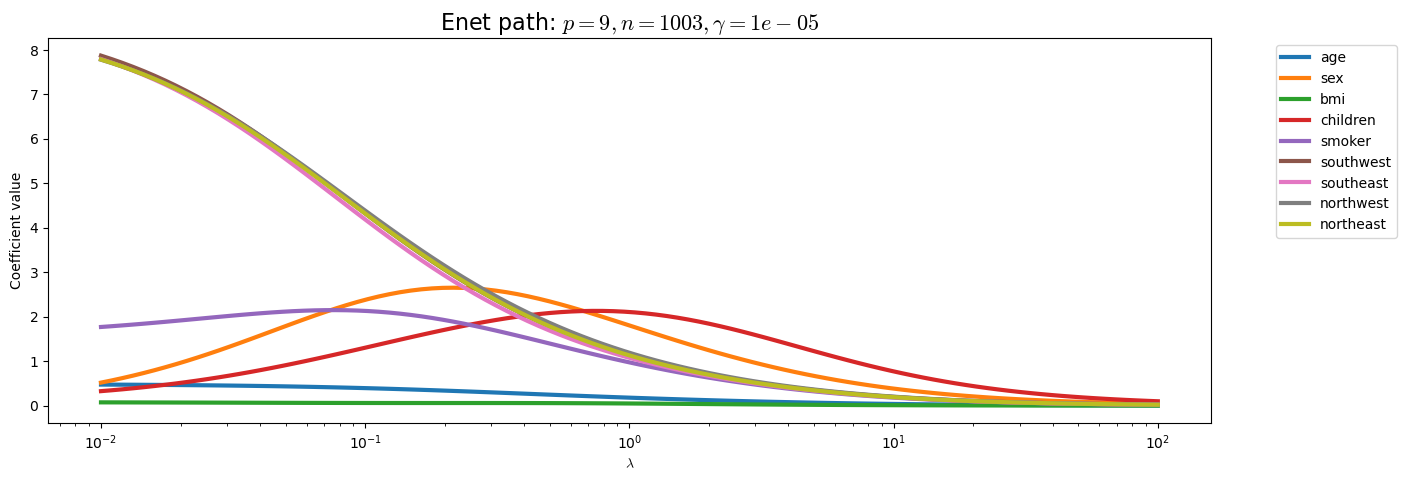

In [28]:
# Ridge (only L2-loss)
theta_enet001 = enet_plot(0.00001,X_train,y_train,lambda_lasso,name_features)

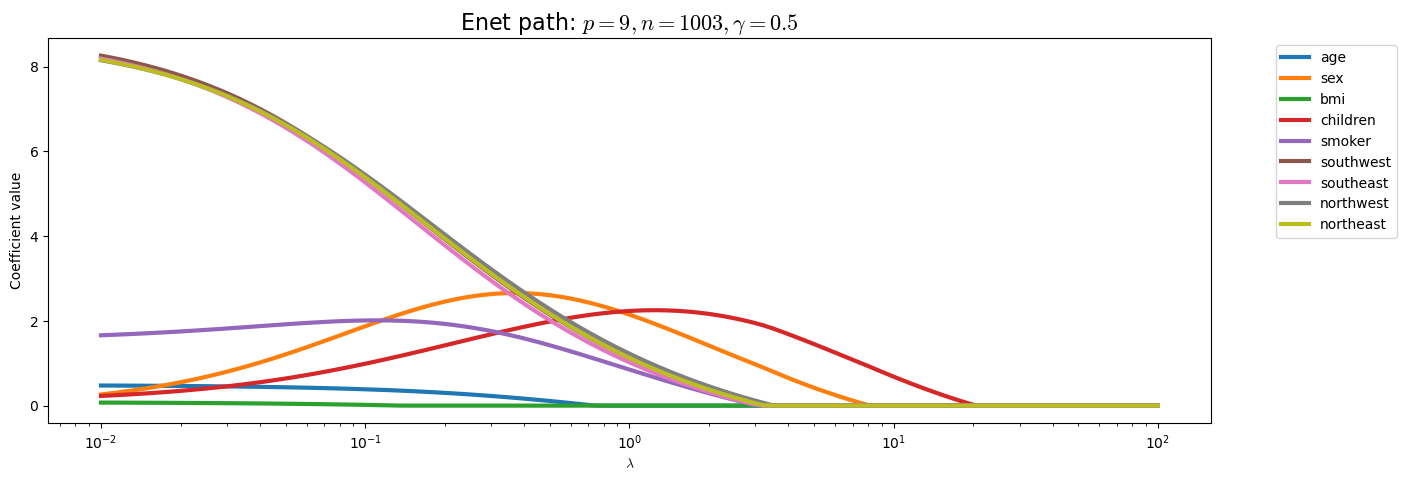

In [29]:
# E-net (both L2-loss and L1-loss)
theta_enet05 = enet_plot(0.5,X_train,y_train,lambda_lasso,name_features)

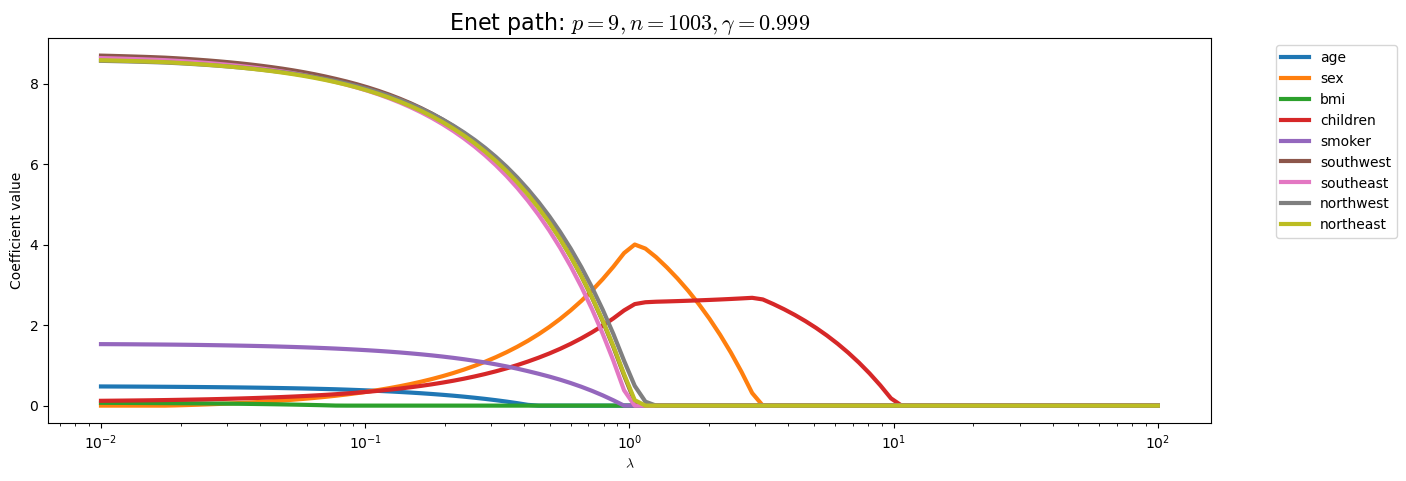

In [30]:
# Lasso (only L1-loss)
theta_enet099 = enet_plot(0.999,X_train,y_train,lambda_lasso,name_features)

It seems that `sex` and `children` are important factors for non-smoking people `smoker=0`and that the four regions have the same importance. What happens if we ignore the region features ? Try to look at that

In [31]:
X_new_train=X_train.drop(['southwest','northwest','southeast','northeast'], axis = 1)
X_new_test=X_test.drop(['southwest','northwest','southeast','northeast'], axis = 1)

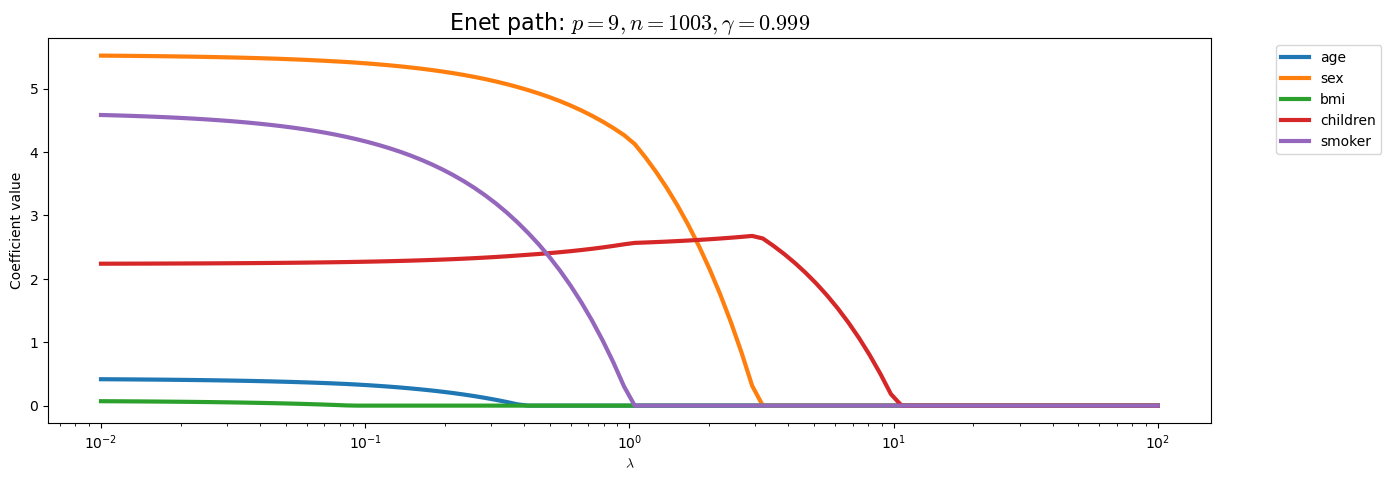

In [32]:
# Lasso (only L1-loss)
theta_enet099 = enet_plot(0.999,X_new_train,y_train,lambda_lasso,X_new_train.columns)

`children`, `sex` and `smoker` seem to be more important than age.
Let's try to use other methods with Cross-validation. 

Remember that also during Cross-validation you should not use test data before the prediction. This means that you should re-fit Standard Scaler at each fold using only the training part and not the test part. In order to be able to do that, you could use a `pipeline`

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# SVR linear
scaler = StandardScaler()
svr = SVR(kernel='linear')
# here we build the pipeline in the right order (first scaling and then fitting)
pipe = Pipeline(steps=[('scaler', scaler), ('svr', svr)])
# here we choose the hyperparameter of the model
parameteres = {'svr__C': [0.001,0.1,1,10]}
# here we use GridSearchCV to look for the best hyper-parameters
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
# once found the best hyper-parameters we compute the test score
print('CV score for linear SVR is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)


# SVR linear
scaler = StandardScaler()
svr = SVR(kernel='rbf')
pipe = Pipeline(steps=[('scaler', scaler), ('svr', svr)])
parameteres = {'svr__C': [0.001,0.1,1,10], 'svr__gamma':[0.01,0.1,1,10]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
print('CV score for rbf SVR is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)

# KNN
scaler = StandardScaler()
KNN = KNeighborsRegressor()
pipe = Pipeline(steps=[('scaler', scaler), ('KNN', KNN)])
parameteres = {'KNN__n_neighbors': [2,5,8,10,20]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
print('CV score for KNN is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)

CV score for linear SVR is : 0.7602594785792438
Best hyperparameters:  {'svr__C': 0.1}
CV score for rbf SVR is : 0.83059098206712
Best hyperparameters:  {'svr__C': 10, 'svr__gamma': 0.1}
CV score for KNN is : 0.795466728107321
Best hyperparameters:  {'KNN__n_neighbors': 8}


Let's try to use Decision Trees based methods.
For Decision trees, we will focus on two hyperparameters: 'min_samples_split', the minimum number of samples required to split an internal node and 'min_samples_leaf', the minimum number of samples required to be at a leaf node. Other hyperparameters exist. Please have a look at the website of scikit-learn

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Decision Trees
scaler = StandardScaler()
Tree = DecisionTreeRegressor()
pipe = Pipeline(steps=[('scaler', scaler), ('Tree', Tree)])
parameteres = {'Tree__min_samples_split': [1,2,5,10,15,20,25], 'Tree__min_samples_leaf': [1,2,5,10,15]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
print('CV score for decision tree is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)


CV score for decision tree is : 0.8172629741232396
Best hyperparameters:  {'Tree__min_samples_leaf': 15, 'Tree__min_samples_split': 2}


To plot decision trees, we can also use the *tree* library from scikit-learn.
More information at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html 

This makes decision trees highly interpretable.   
**Question**: which are the most important features ?  
**Answer**: selon l'arbre la variable la plus discriminante est fumeur ou non fumeur. Viennent ensuite les variables d'âge et bmi.

[Text(0.5, 0.9, 'smoker <= 0.5\nsquared_error = 0.845\nsamples = 1338\nvalue = 9.099'),
 Text(0.25, 0.7, 'age <= 32.5\nsquared_error = 0.553\nsamples = 1064\nvalue = 8.788'),
 Text(0.125, 0.5, 'children <= 0.5\nsquared_error = 0.47\nsamples = 392\nvalue = 8.107'),
 Text(0.0625, 0.3, 'age <= 22.5\nsquared_error = 0.363\nsamples = 207\nvalue = 7.816'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'age <= 22.5\nsquared_error = 0.388\nsamples = 185\nvalue = 8.432'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'age <= 46.5\nsquared_error = 0.173\nsamples = 672\nvalue = 9.186'),
 Text(0.3125, 0.3, 'age <= 42.5\nsquared_error = 0.119\nsamples = 288\nvalue = 8.882'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'age <= 51.5\nsquared_error = 0.093\nsamples = 384\nvalue = 9.414'),
 Text(0.40625, 0.1, '\n  (...)  \n'),
 Text(0.46875, 0.1, '\n  (...)

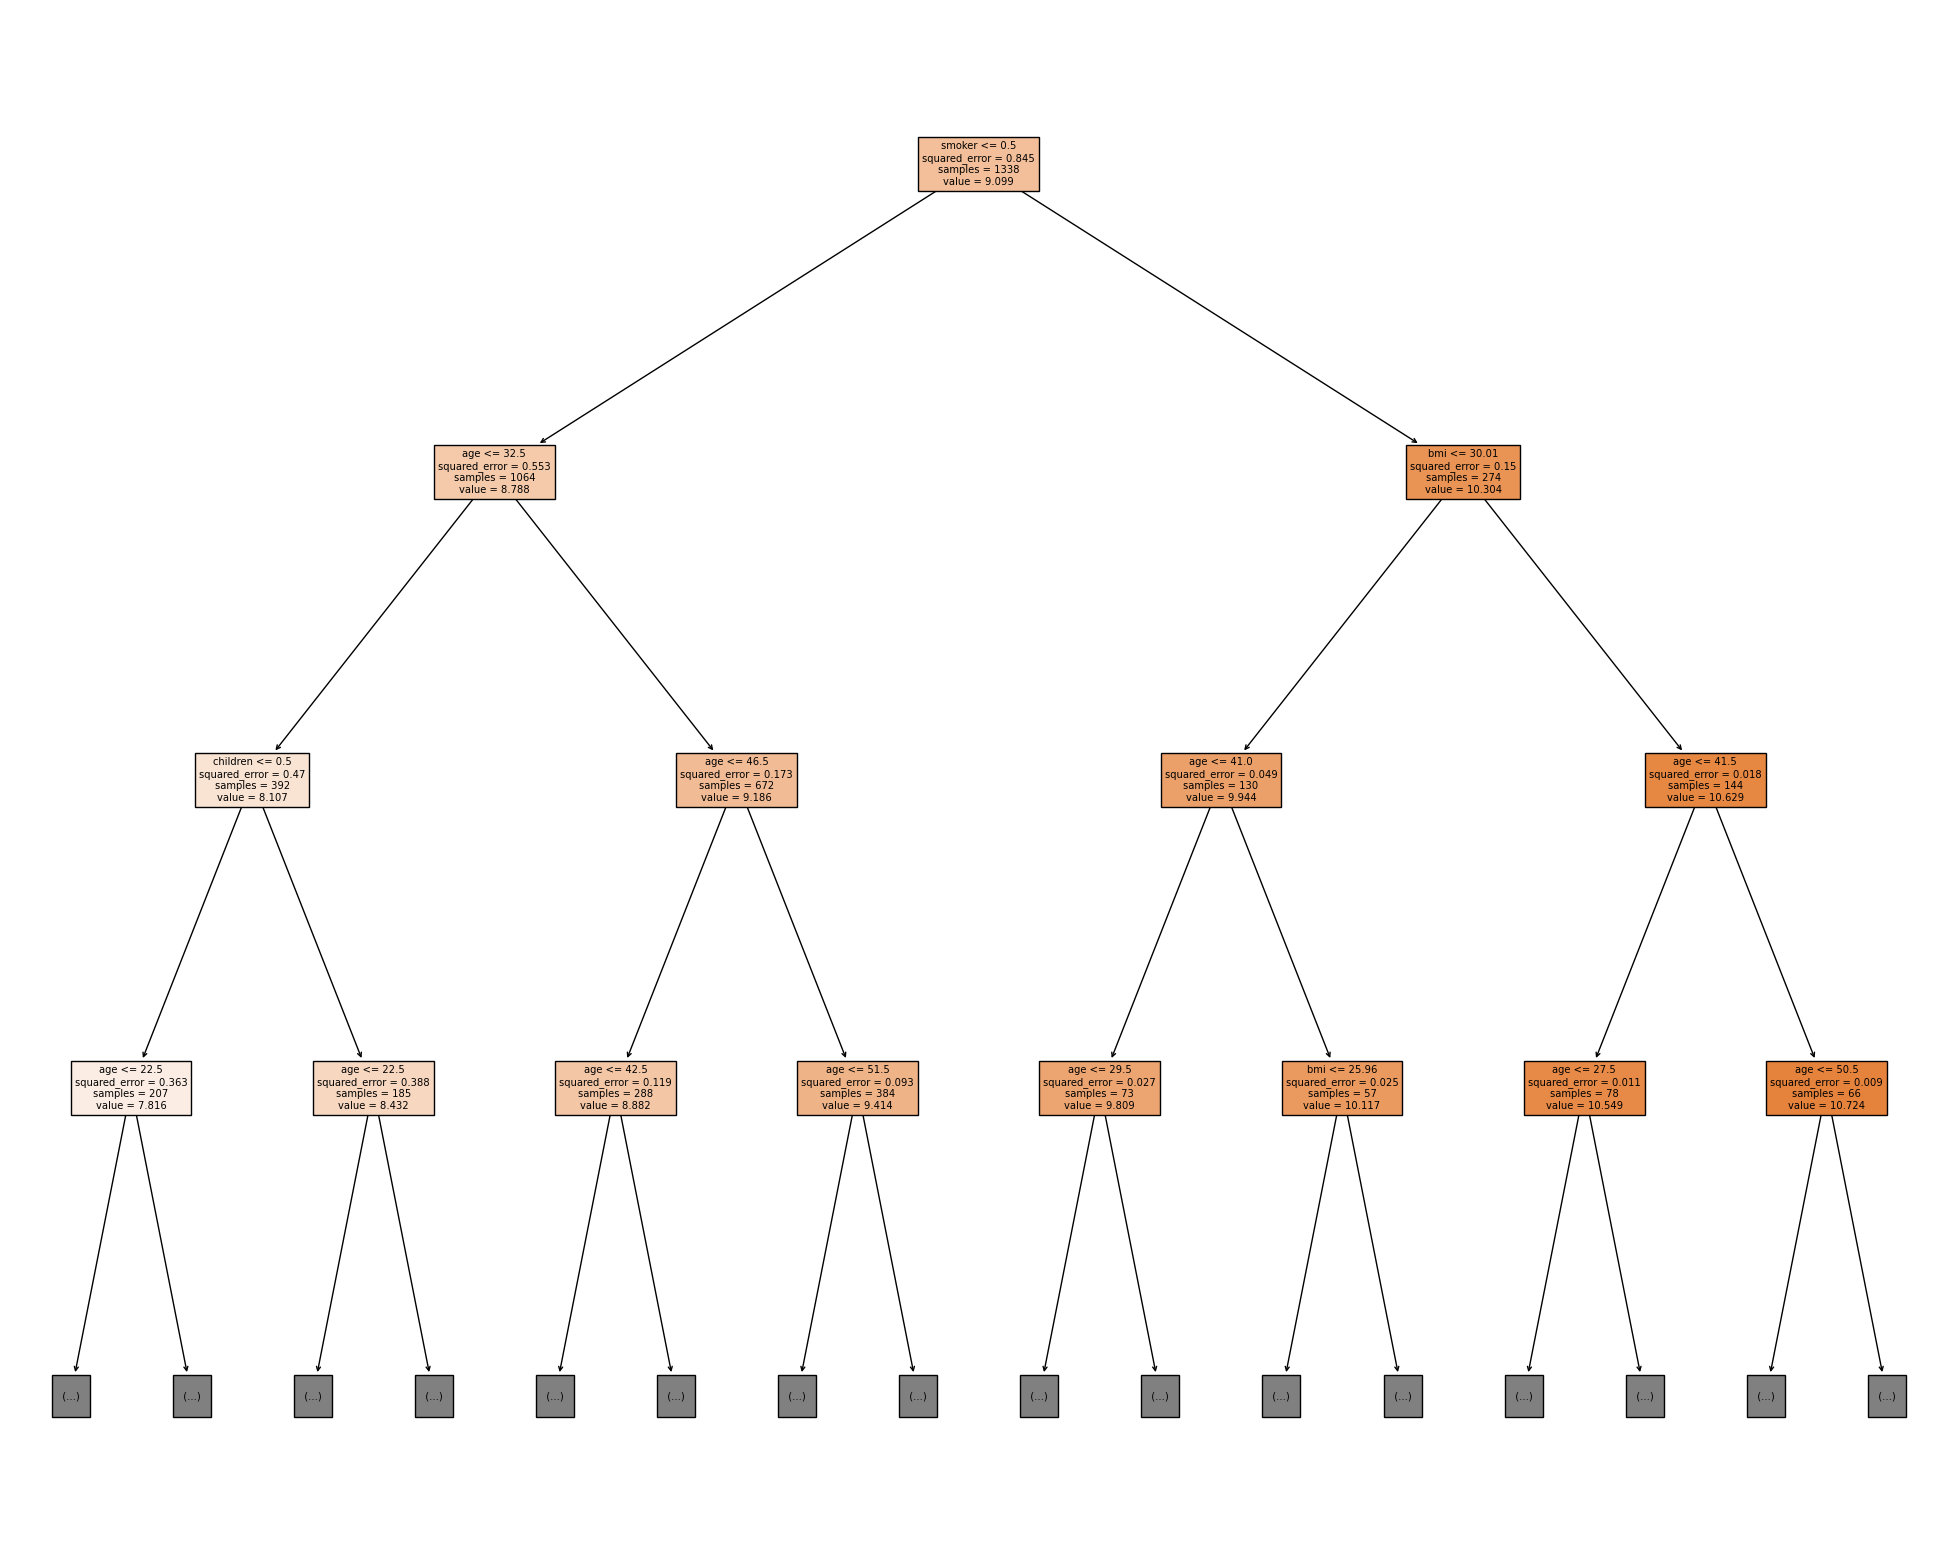

In [35]:
from sklearn import tree

Tree = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=15)
Tree.fit(X,y)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(Tree, feature_names = name_features, max_depth=3, filled = True)
#fig.savefig('imagename.png')


In [36]:
# Bagging
scaler = StandardScaler()
treeBagging = BaggingRegressor()
pipe = Pipeline(steps=[('scaler', scaler), ('treeBagging', treeBagging)])
parameteres = {'treeBagging__n_estimators': [10,20,50], 'treeBagging__max_samples': [0.2,0.5,0.6,0.9]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
print('CV score for bagging with decision tree is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)

# Random Forest
scaler = StandardScaler()
RF = RandomForestRegressor()
pipe = Pipeline(steps=[('scaler', scaler), ('RF', RF)])
parameteres = {'RF__n_estimators': [10,20,50], 'RF__min_samples_split': [2,5,10], 'RF__min_samples_leaf': [2,5,10],'RF__max_samples': [0.2,0.5,0.6]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
print('CV score for random forest is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)

# Adaboost
scaler = StandardScaler()
adaboost = AdaBoostRegressor()
pipe = Pipeline(steps=[('scaler', scaler), ('adaboost', adaboost)])
parameteres = {'adaboost__n_estimators': [10,20,50]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train,y_train)
print('CV score for AdaBoost is :', grid.score(X_test,y_test))
print('Best hyperparameters: ',grid.best_params_)

CV score for bagging with decision tree is : 0.8280458105519812
Best hyperparameters:  {'treeBagging__max_samples': 0.2, 'treeBagging__n_estimators': 50}
CV score for random forest is : 0.8319979162123808
Best hyperparameters:  {'RF__max_samples': 0.6, 'RF__min_samples_leaf': 5, 'RF__min_samples_split': 2, 'RF__n_estimators': 50}
CV score for AdaBoost is : 0.7274825615685478
Best hyperparameters:  {'adaboost__n_estimators': 10}


We can use random Forest to compute importance of features

Feature ranking:
1. feature smoker (0.486751)
2. feature age (0.396496)
3. feature bmi (0.053883)
4. feature children (0.041678)
5. feature sex (0.007049)
6. feature southwest (0.006831)
7. feature southeast (0.003606)
8. feature northwest (0.002192)
9. feature northeast (0.001515)


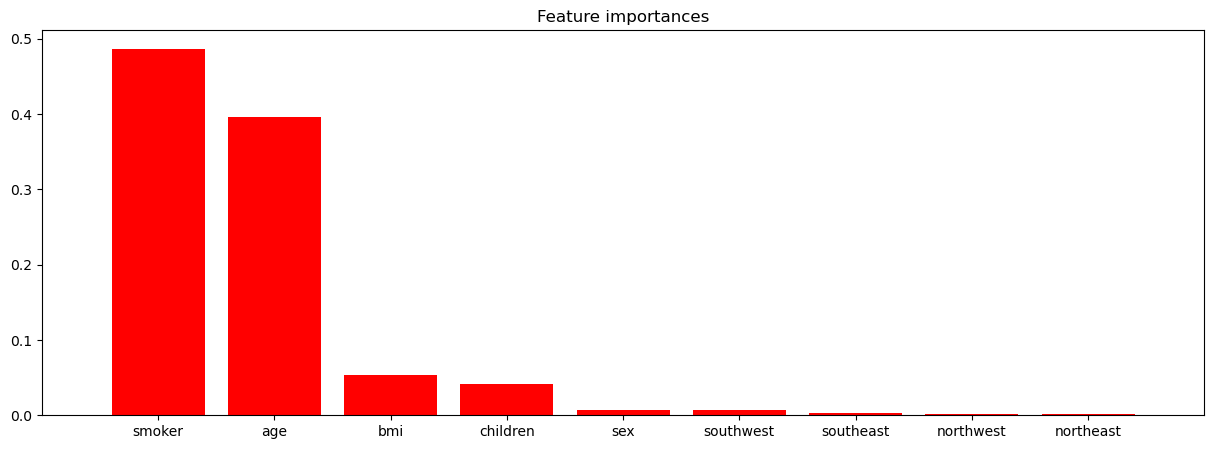

In [37]:
RF = RandomForestRegressor(max_samples=0.6, min_samples_leaf=5, min_samples_split=5, n_estimators=50)
RF.fit(X,y)
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

We can see that the most important features are `smoker` and `age`.   
Attention : chez les fumeurs, le bmi est pourtant une variable importante mais comme il y a très peu de fumeurs, le bmi ne remonte pas beaucoup dans le graphique ci-dessus.

**Question**: it's still not clear whether the region features are important or not. And what about the number of children ? Try to answer these questions by squeezing a little bit more the data

Est ce qu'on pourrait pas faire un modèle fumeur et un modèle non fumeur ? ET quelles sont les variables les plus importantes dans ce cas ?

Normalization or standardization ?

sex et children à prendre en compte quand non fumeurs !!!!

c'est quoi la variable qui fait que des non fumeurs se retrouvent au milieu du graphique ?

### Analyse exploratoire : variable `children`

Nous allons regarder parmis les non fumeurs s'il y a une différence entre ceux ayant des enfants ou non.

Text(0.5, 0, 'age')

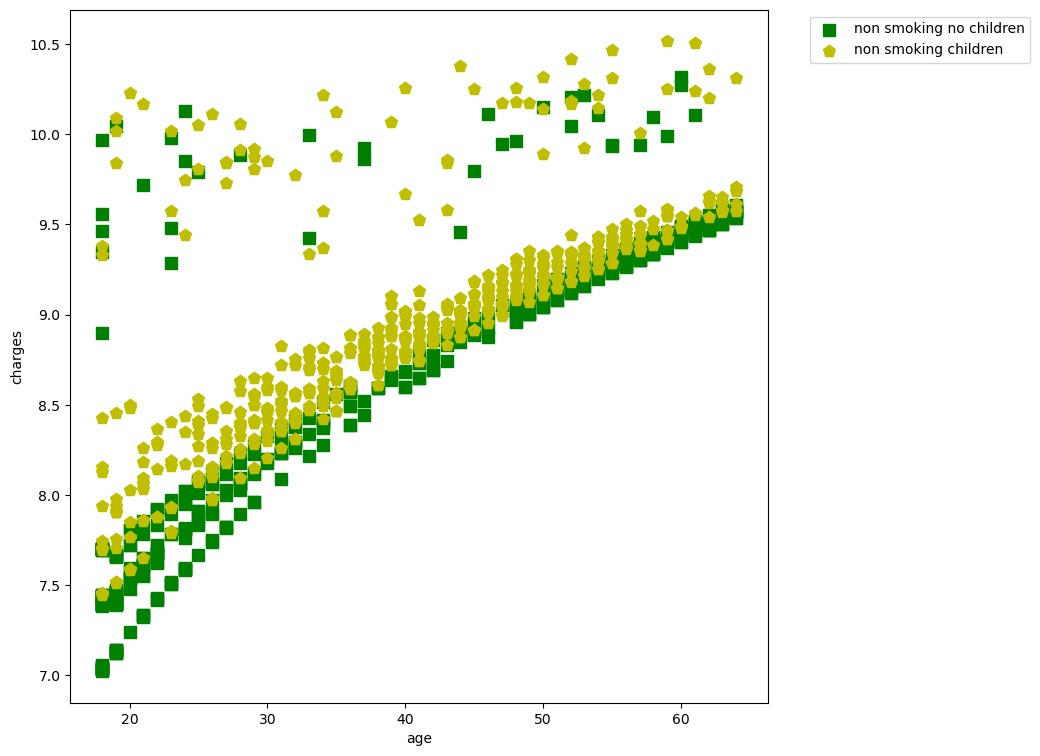

In [50]:
fig1 = plt.figure(figsize=(9, 9))
ax = plt.gca()

plt.scatter(dataOHE[(dataOHE.smoker==0) & (dataOHE.children==0)].age, dataOHE[(dataOHE.smoker==0) & (dataOHE.children==0)].charges,
                c='g',s=80, marker='s',label='non smoking no children')
plt.scatter(dataOHE[(dataOHE.smoker==0) & (dataOHE.children>0)].age, dataOHE[(dataOHE.smoker==0) & (dataOHE.children>0)].charges,
                c='y',s=80, marker='p',label='non smoking children')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('charges')
plt.xlabel('age')

Nous constatons que les non fumeurs avec enfant(s) payent un peu plus de charges que ceux sans enfant.

### Création de 2 modèles séparés : un modèle sur les fumeurs et un modèle sur les non fumeurs

Nous allons faire un modèle fumeur et un modèle non fumeur. Il faut donc créer les datasets X et y pour chacun des modèles :

In [39]:
y_smoker = dataOHE[(dataOHE.smoker == 1)].charges
y_nonsmoker = dataOHE[(dataOHE.smoker == 0)].charges
X_smoker = dataOHE[(dataOHE.smoker == 1)].drop(['charges','smoker'], axis = 1)
X_nonsmoker = dataOHE[(dataOHE.smoker == 0)].drop(['charges','smoker'], axis = 1)

name_features_smoker=X_smoker.columns
name_features_nonsmoker=X_nonsmoker.columns

Découpage en échantillons train /test + Standardization:

In [ ]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [60]:
X_train_smoker, X_test_smoker, y_train_smoker, y_test_smoker = train_test_split(X_smoker, y_smoker, test_size=0.25, random_state=42)
X_train_nonsmoker, X_test_nonsmoker, y_train_nonsmoker, y_test_nonsmoker = train_test_split(X_nonsmoker, y_nonsmoker, test_size=0.25, random_state=42)

# Standardization
scaler_smoker = StandardScaler()
scaler_nonsmoker = StandardScaler()
scaler_smoker.fit(X_train_smoker[['age','bmi']])
scaler_nonsmoker.fit(X_train_nonsmoker[['age','bmi']])
X_train_smoker[['age','bmi']] = scaler_smoker.transform(X_train_smoker[['age','bmi']])
X_train_nonsmoker[['age','bmi']] = scaler_nonsmoker.transform(X_train_nonsmoker[['age','bmi']])
X_test_smoker[['age','bmi']] = scaler_smoker.transform(X_test_smoker[['age','bmi']])
X_test_nonsmoker[['age','bmi']] = scaler_nonsmoker.transform(X_test_nonsmoker[['age','bmi']])

# Normalization
# norm_smoker = MinMaxScaler().fit(X_train_smoker[['age','bmi']])
# norm_nonsmoker = MinMaxScaler().fit(X_train_nonsmoker[['age','bmi']])
# X_train_smoker[['age','bmi']] = norm_smoker.transform(X_train_smoker[['age','bmi']])
# X_train_nonsmoker[['age','bmi']] = norm_nonsmoker.transform(X_train_nonsmoker[['age','bmi']])
# X_test_smoker[['age','bmi']] = norm_smoker.transform(X_test_smoker[['age','bmi']])
# X_test_nonsmoker[['age','bmi']] = norm_nonsmoker.transform(X_test_nonsmoker[['age','bmi']])

Test des méthodes de régression linéaire / Ridge / Lasso :

In [61]:
linear_smoker = LinearRegression(normalize=False,fit_intercept=False)
linear_nonsmoker = LinearRegression(normalize=False,fit_intercept=False)
linear_smoker.fit(X_train_smoker, y_train_smoker)
linear_nonsmoker.fit(X_train_nonsmoker, y_train_nonsmoker)
print('Training score smoker: ',linear_smoker.score(X_train_smoker, y_train_smoker), '; Test score smoker: ', linear_smoker.score(X_test_smoker, y_test_smoker))
print('Training score non smoker: ',linear_nonsmoker.score(X_train_nonsmoker, y_train_nonsmoker), '; Test score non smoker: ', linear_nonsmoker.score(X_test_nonsmoker, y_test_nonsmoker))

ridge_smoker = Ridge(normalize=False,fit_intercept=False)
ridge_nonsmoker = Ridge(normalize=False,fit_intercept=False)
ridge_smoker.fit(X_train_smoker, y_train_smoker)
ridge_nonsmoker.fit(X_train_nonsmoker, y_train_nonsmoker)
print('Ridge smoker: ',ridge_smoker.score(X_test_smoker, y_test_smoker))
print('Ridge non smoker: ',ridge_nonsmoker.score(X_test_nonsmoker, y_test_nonsmoker))

lasso_smoker = Lasso(alpha=1e-3, normalize=False,fit_intercept=False)
lasso_nonsmoker = Lasso(alpha=1e-3, normalize=False,fit_intercept=False)
lasso_smoker.fit(X_train_smoker, y_train_smoker)
lasso_nonsmoker.fit(X_train_nonsmoker, y_train_nonsmoker)
print('Lasso smoker: ',lasso_smoker.score(X_test_smoker, y_test_smoker))
print('Lasso non smoker: ',lasso_nonsmoker.score(X_test_nonsmoker, y_test_nonsmoker))

Training score smoker:  0.771725623179714 ; Test score smoker:  0.7182565251699957
Training score non smoker:  0.682181688938881 ; Test score non smoker:  0.7112509043000002
Ridge smoker:  -0.9498258641071655
Ridge non smoker:  0.6847396675055311
Lasso smoker:  0.7161509973808349
Lasso non smoker:  0.7108294370922305


Avec ces premières méthodes de régression linéaire, Ridge et Lasso, les performances des 2 modèles smoker vs non smoker semblent à peu près similaires sur les échantillons de tests

Vérification de comment les poids des paramètres changent lors de l'utilisation d'une régularisation de norme L2 (Ridge) ou d'une norme L1 (Lasso) ou les deux (E-net) :

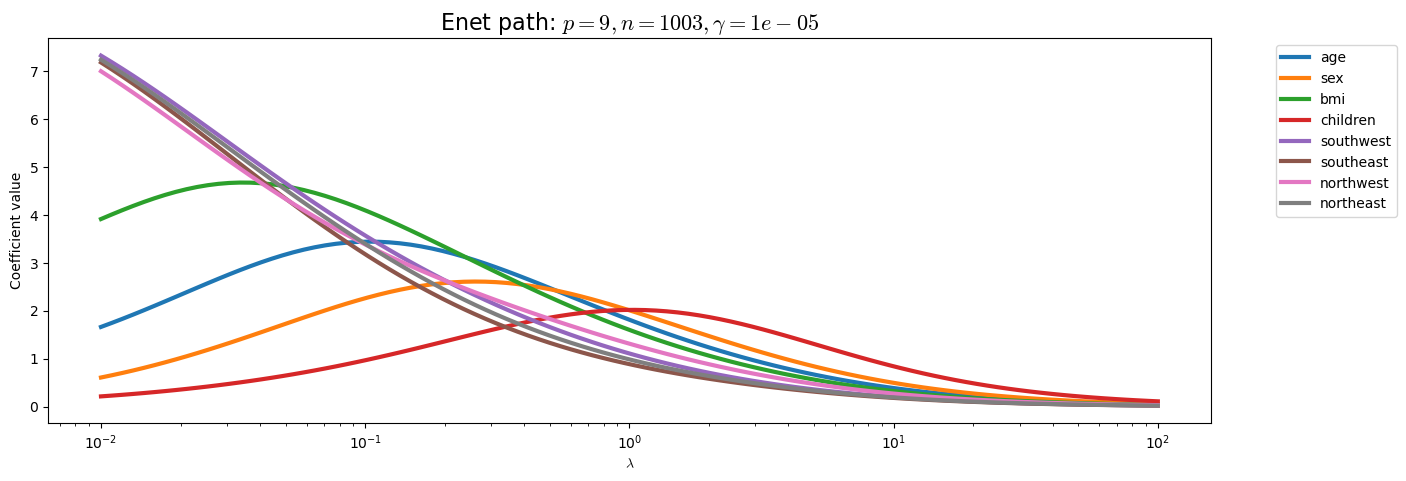

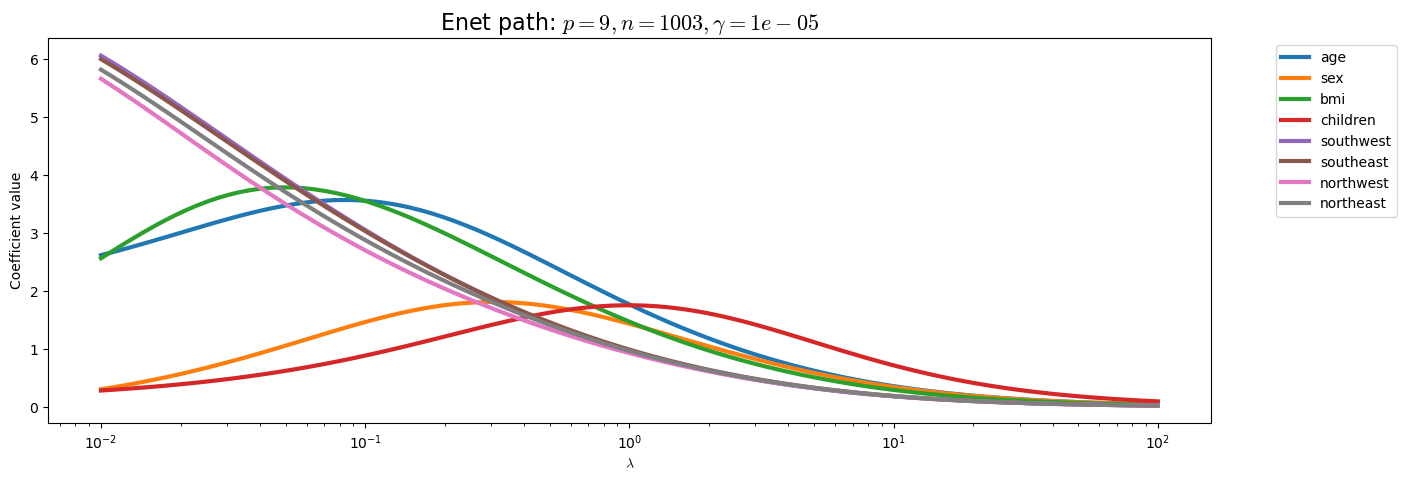

In [62]:
# Ridge (only L2-loss)
theta_enet001_smoker = enet_plot(0.00001,X_train_smoker,y_train_smoker,lambda_lasso,name_features_smoker)
theta_enet001_nonsmoker = enet_plot(0.00001,X_train_nonsmoker,y_train_nonsmoker,lambda_lasso,name_features_nonsmoker)

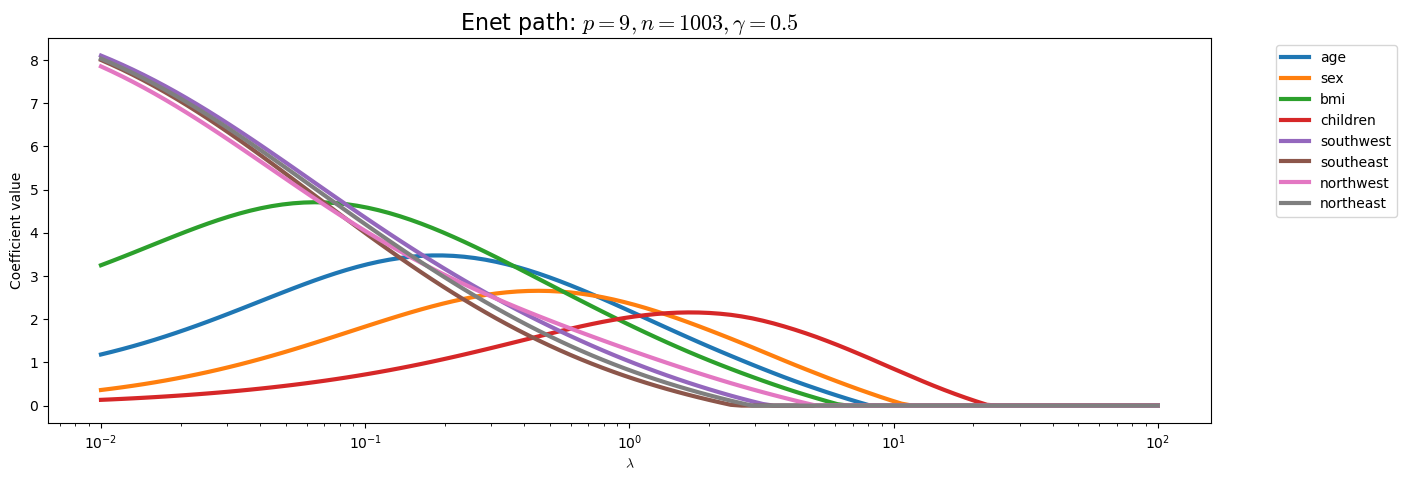

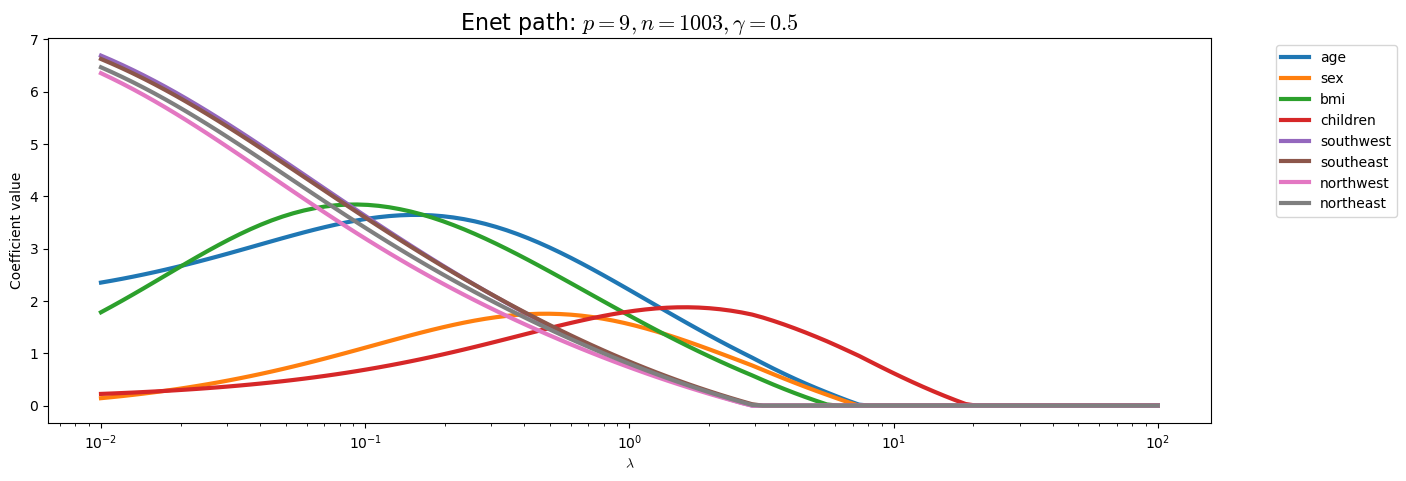

In [63]:
# E-net (both L2-loss and L1-loss)
theta_enet05_smoker = enet_plot(0.5,X_train_smoker,y_train_smoker,lambda_lasso,name_features_smoker)
theta_enet05_nonsmoker = enet_plot(0.5,X_train_nonsmoker,y_train_nonsmoker,lambda_lasso,name_features_nonsmoker)

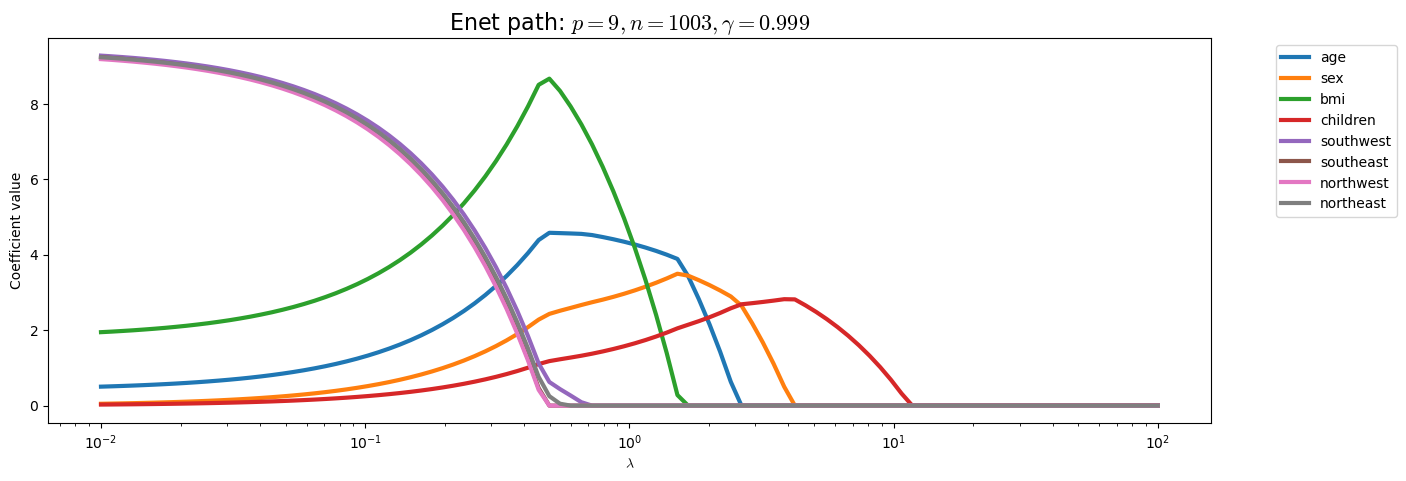

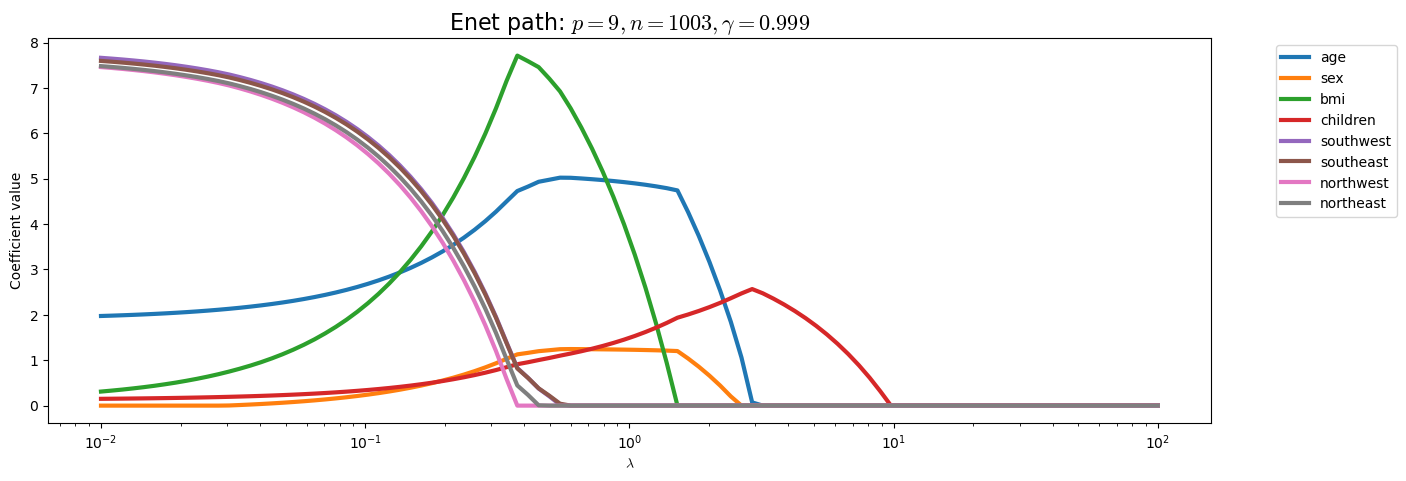

In [64]:
# Lasso (only L1-loss)
theta_enet099_smoker = enet_plot(0.999,X_train_smoker,y_train_smoker,lambda_lasso,name_features_smoker)
theta_enet099_nonsmoker = enet_plot(0.999,X_train_nonsmoker,y_train_nonsmoker,lambda_lasso,name_features_nonsmoker)


Pour le modèle fumeurs, les variables les plus importantes semblent être `children` et `sex`. Les variables de region ne convergent pas toutes vers 0 au même moment. En effet la variable `northwest` semblent avoir un peu plus d'importance que les autres.  
Pour le modèle non fumeurs, les variables les plus importantes semblent être `children` et `sex`. Il ne semble ici pas y avoir de distinction entre les variables de region.

Application de la méthode des arbres de décision sur les modèles fumeurs et non fumeurs :

In [45]:
# Decision Trees
scaler_smoker = StandardScaler()
scaler_nonsmoker = StandardScaler()
Tree_smoker = DecisionTreeRegressor()
Tree_nonsmoker = DecisionTreeRegressor()
pipe_smoker = Pipeline(steps=[('scaler', scaler_smoker), ('Tree', Tree_smoker)])
pipe_nonsmoker = Pipeline(steps=[('scaler', scaler_nonsmoker), ('Tree', Tree_nonsmoker)])
parameteres = {'Tree__min_samples_split': [1,2,5,10,15,20,25], 'Tree__min_samples_leaf': [1,2,5,10,15]}
grid_smoker = GridSearchCV(pipe_smoker, param_grid=parameteres, cv=5)
grid_nonsmoker = GridSearchCV(pipe_nonsmoker, param_grid=parameteres, cv=5)
grid_smoker.fit(X_train_smoker,y_train_smoker)
grid_nonsmoker.fit(X_train_nonsmoker,y_train_nonsmoker)
print('Smoker - CV score for decision tree is :', grid_smoker.score(X_test_smoker,y_test_smoker))
print('Smoker - Best hyperparameters: ',grid_smoker.best_params_)
print('Non Smoker - CV score for decision tree is :', grid_nonsmoker.score(X_test_nonsmoker,y_test_nonsmoker))
print('Non Smoker - Best hyperparameters: ',grid_nonsmoker.best_params_)


Smoker - CV score for decision tree is : 0.879764543865955
Smoker - Best hyperparameters:  {'Tree__min_samples_leaf': 2, 'Tree__min_samples_split': 25}
Non Smoker - CV score for decision tree is : 0.7201222113711234
Non Smoker - Best hyperparameters:  {'Tree__min_samples_leaf': 15, 'Tree__min_samples_split': 10}


Nous constatons ici que le modèle sur les fumeurs offre de meilleurs performances que celui sur les non fumeurs.

Affichage de l'arbre sur le modèle fumeurs :

[Text(0.5416666666666666, 0.9, 'bmi <= 30.01\nsquared_error = 0.15\nsamples = 274\nvalue = 10.304'),
 Text(0.3125, 0.7, 'age <= 41.0\nsquared_error = 0.049\nsamples = 130\nvalue = 9.944'),
 Text(0.16666666666666666, 0.5, 'age <= 29.5\nsquared_error = 0.027\nsamples = 73\nvalue = 9.809'),
 Text(0.08333333333333333, 0.3, 'bmi <= 24.275\nsquared_error = 0.028\nsamples = 41\nvalue = 9.747'),
 Text(0.041666666666666664, 0.1, '\n  (...)  \n'),
 Text(0.125, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.3, 'bmi <= 25.427\nsquared_error = 0.015\nsamples = 32\nvalue = 9.89'),
 Text(0.20833333333333334, 0.1, '\n  (...)  \n'),
 Text(0.2916666666666667, 0.1, '\n  (...)  \n'),
 Text(0.4583333333333333, 0.5, 'bmi <= 25.96\nsquared_error = 0.025\nsamples = 57\nvalue = 10.117'),
 Text(0.4166666666666667, 0.3, 'bmi <= 23.802\nsquared_error = 0.015\nsamples = 30\nvalue = 10.043'),
 Text(0.375, 0.1, '\n  (...)  \n'),
 Text(0.4583333333333333, 0.1, '\n  (...)  \n'),
 Text(0.5, 0.3, 'squared_error = 0.023\nsamples =

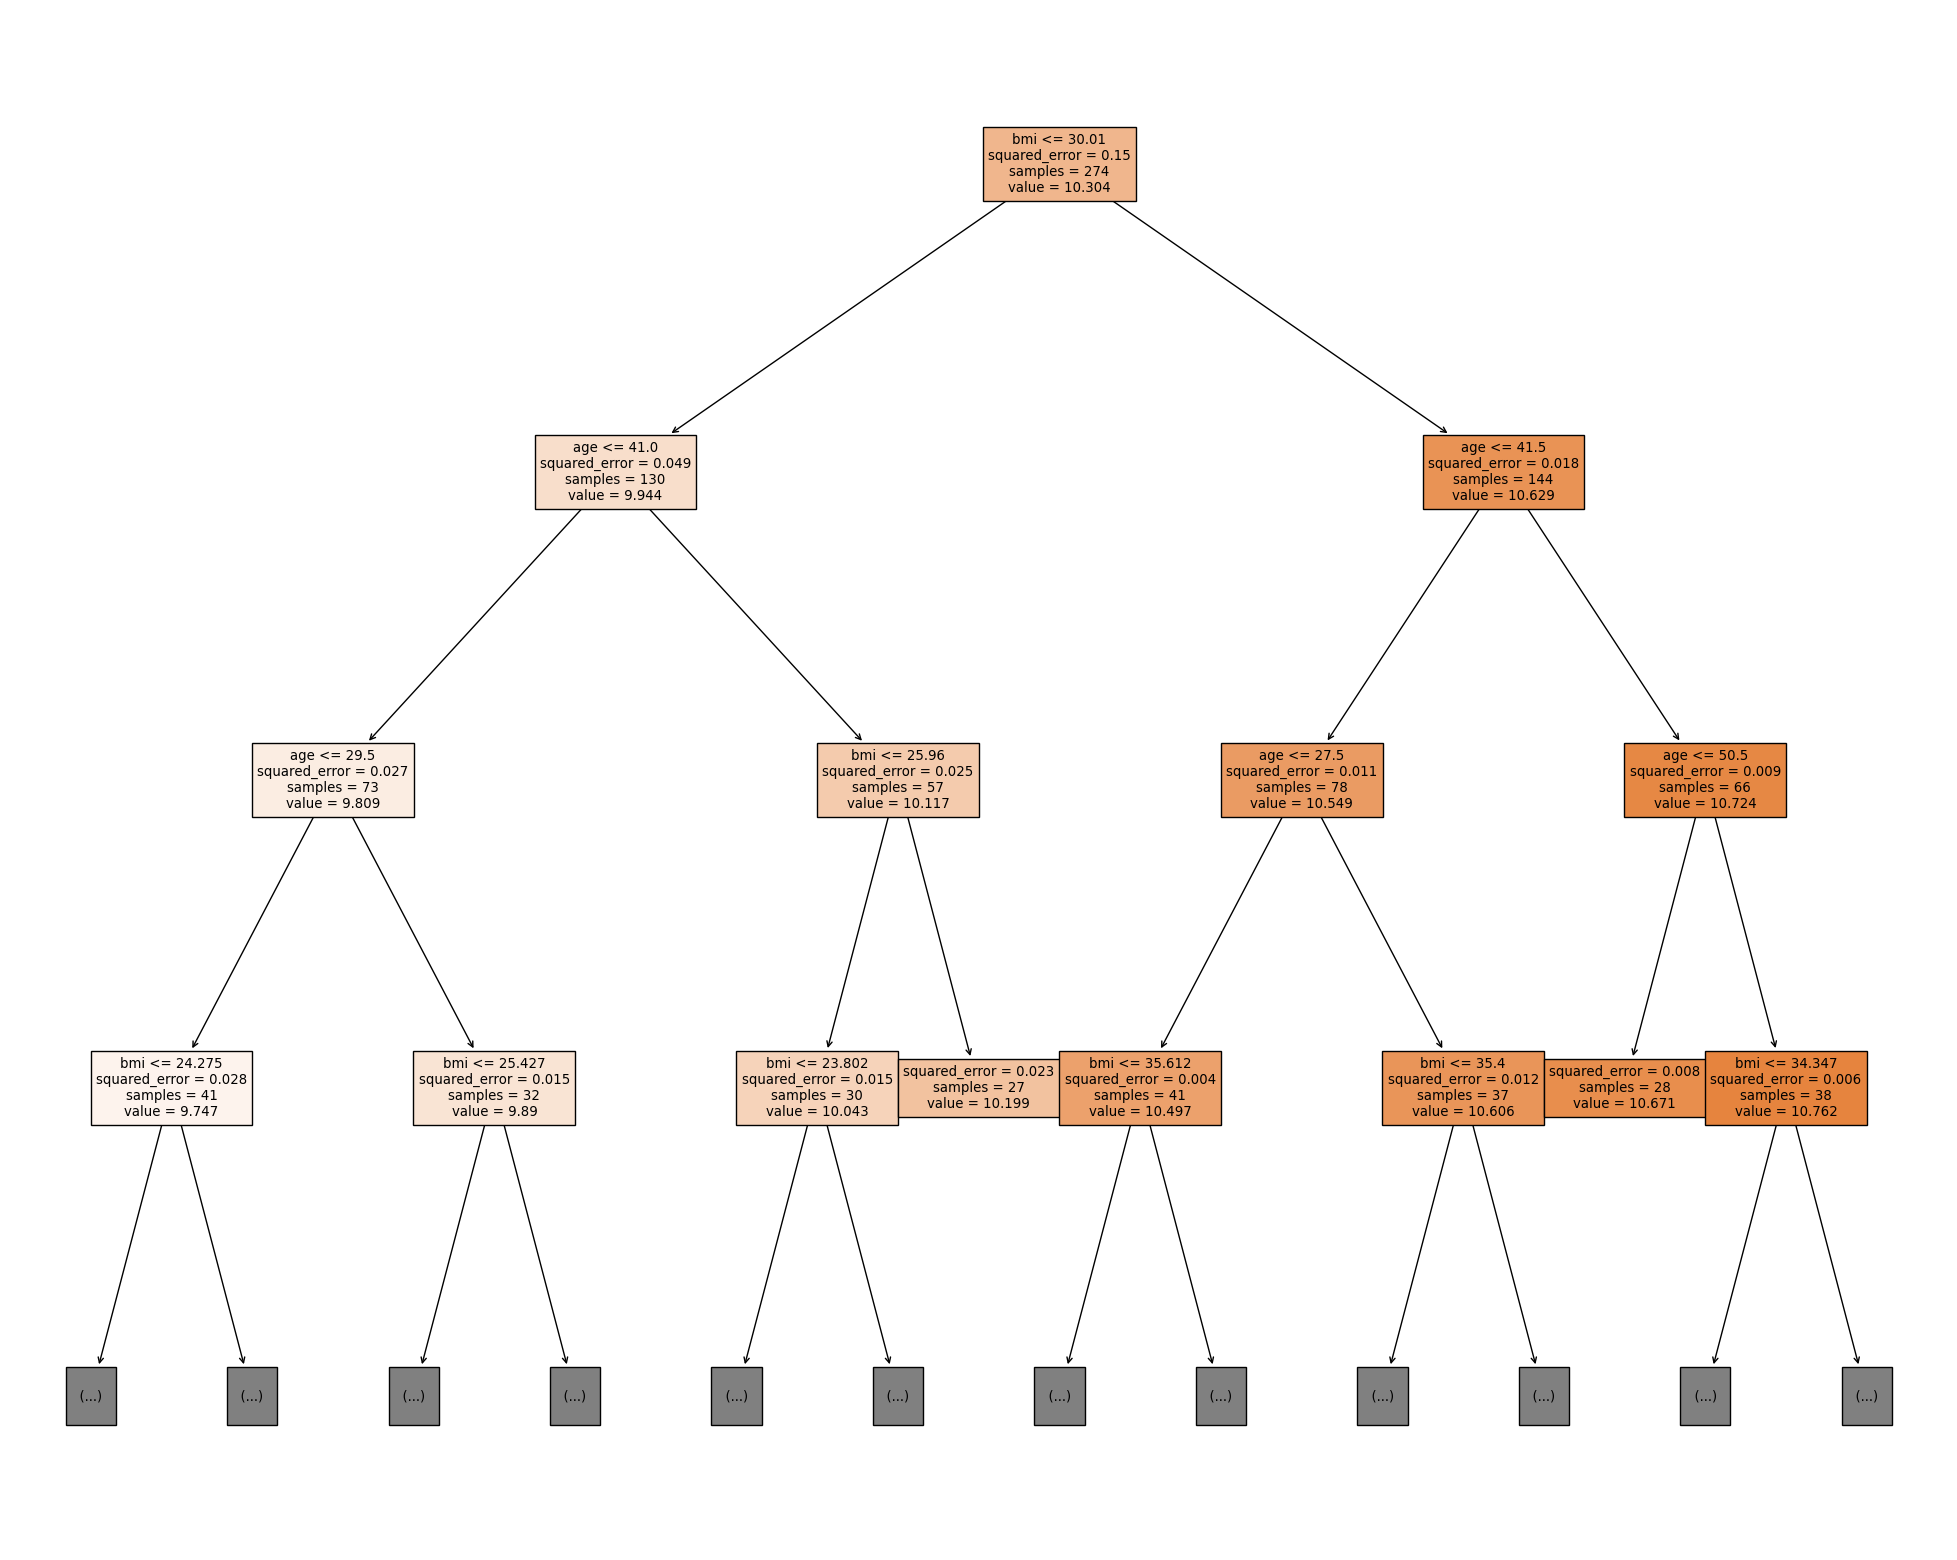

In [46]:
Tree_smoker = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=15)
Tree_smoker.fit(X_smoker,y_smoker)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(Tree_smoker, feature_names = name_features_smoker, max_depth=3, filled = True)

Nous constatons avec l'arbre que les variables les plus importantes sur le modèle fumeurs sont `bmi` et `age`.

Affichage de l'arbre sur le modèle non fumeurs :

[Text(0.5, 0.9, 'age <= 32.5\nsquared_error = 0.553\nsamples = 1064\nvalue = 8.788'),
 Text(0.25, 0.7, 'children <= 0.5\nsquared_error = 0.47\nsamples = 392\nvalue = 8.107'),
 Text(0.125, 0.5, 'age <= 22.5\nsquared_error = 0.363\nsamples = 207\nvalue = 7.816'),
 Text(0.0625, 0.3, 'sex <= 0.5\nsquared_error = 0.295\nsamples = 121\nvalue = 7.596'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'sex <= 0.5\nsquared_error = 0.295\nsamples = 86\nvalue = 8.125'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'age <= 22.5\nsquared_error = 0.388\nsamples = 185\nvalue = 8.432'),
 Text(0.3125, 0.3, 'children <= 1.5\nsquared_error = 0.526\nsamples = 54\nvalue = 8.162'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'southwest <= 0.5\nsquared_error = 0.289\nsamples = 131\nvalue = 8.544'),
 Text(0.40625, 0.1, '\n  (...)  \n'),
 Text(0.46875, 0.1, '\n  (..

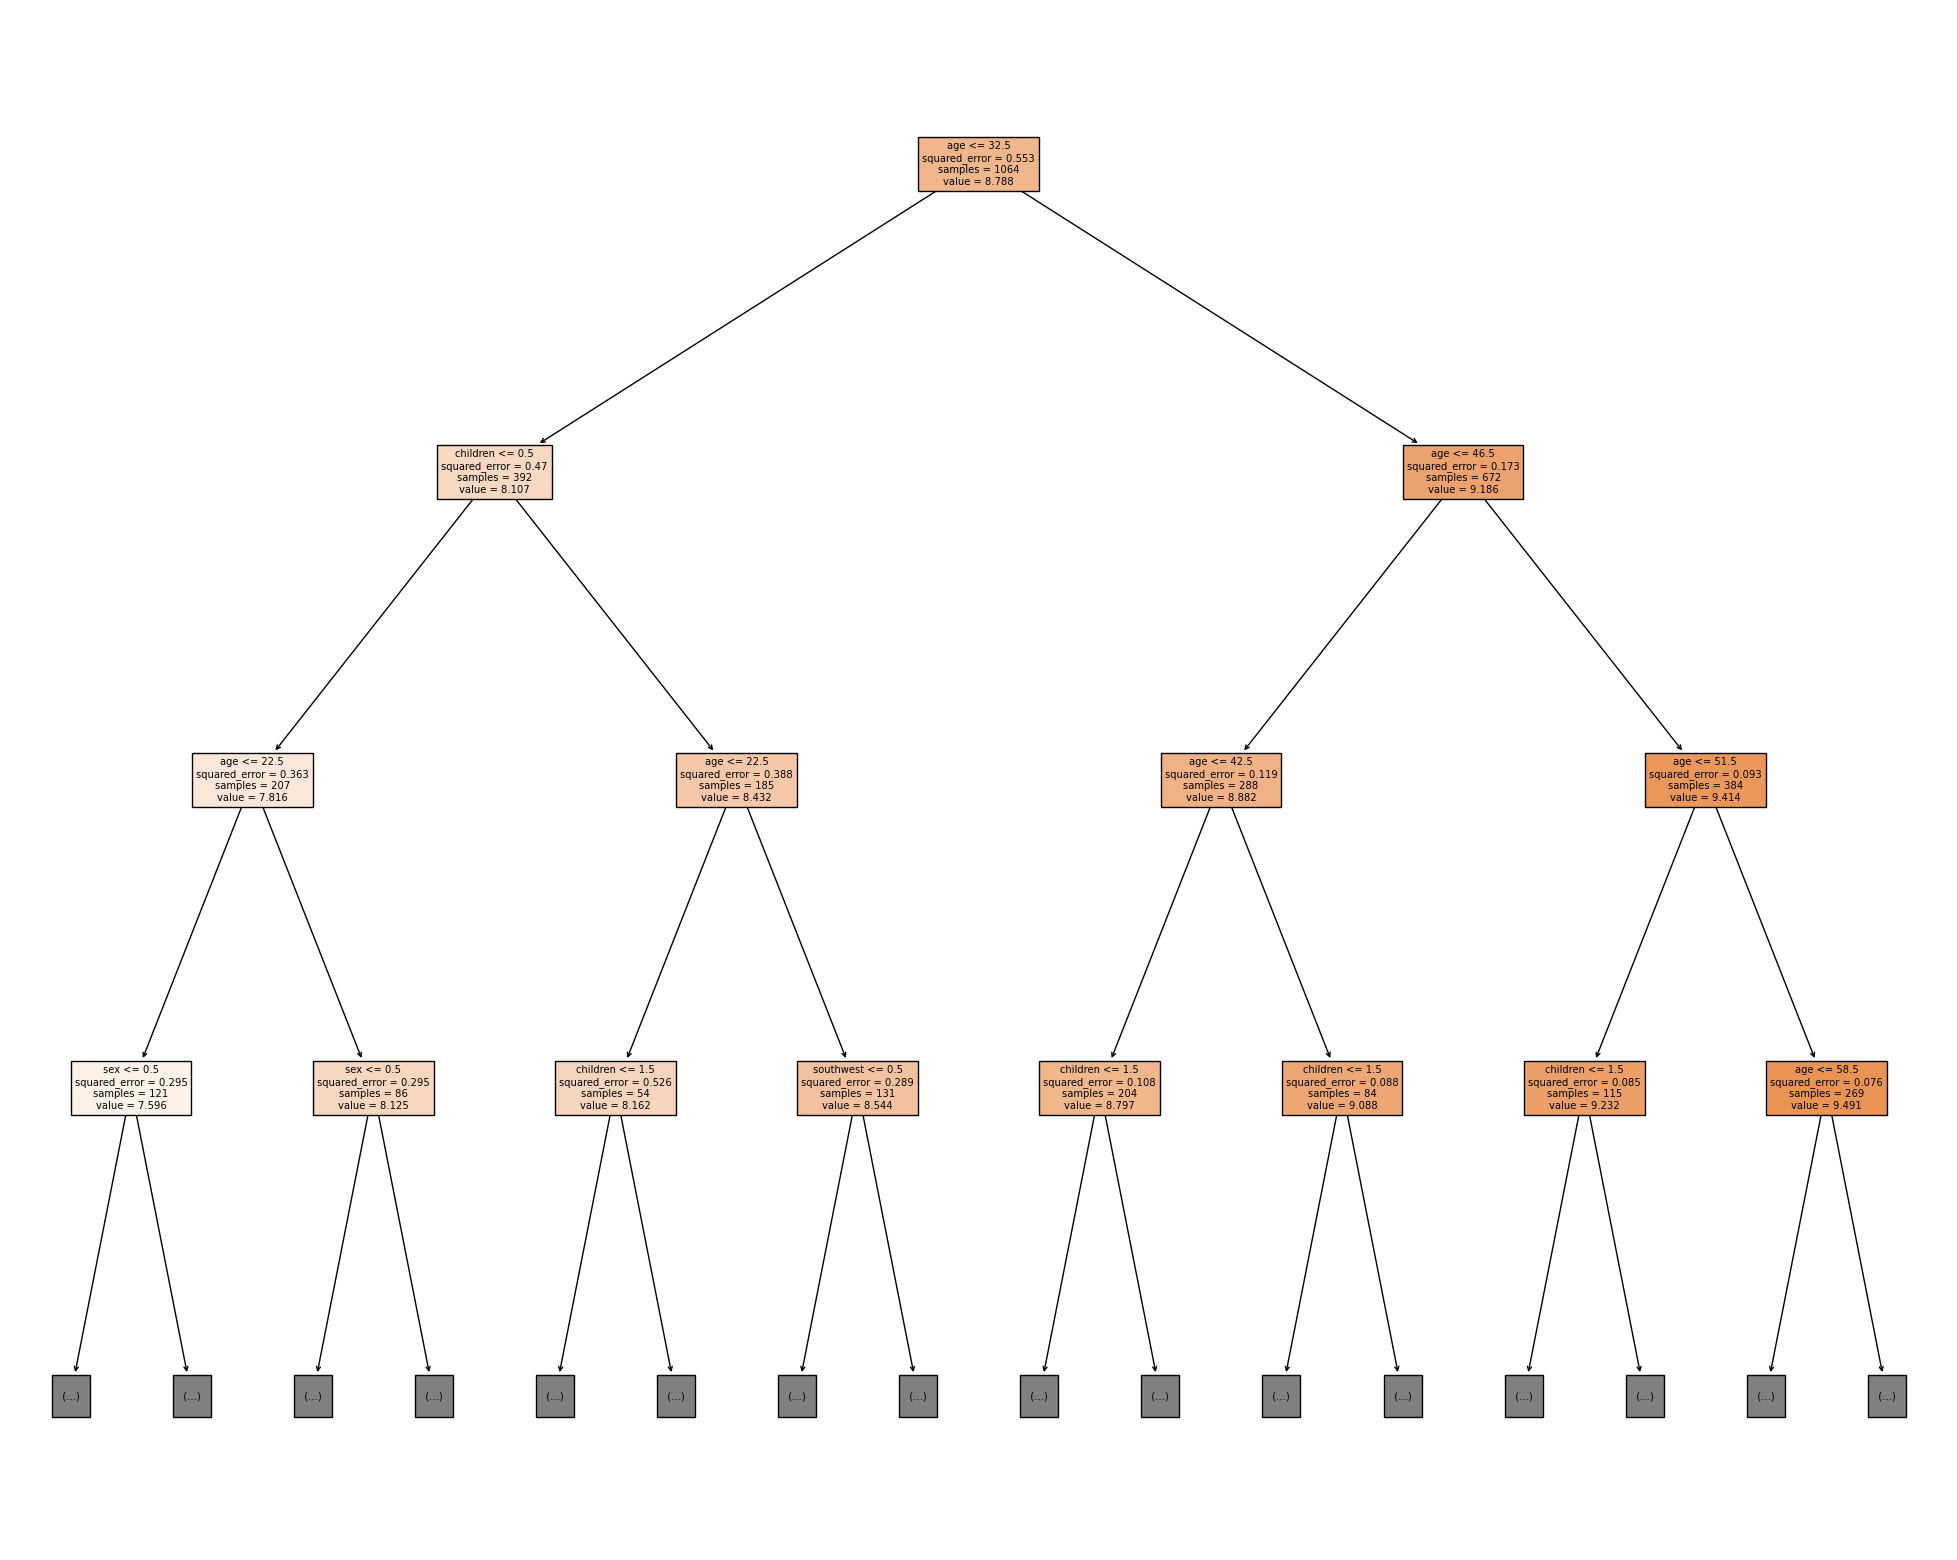

In [47]:
Tree_nonsmoker = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=15)
Tree_nonsmoker.fit(X_nonsmoker,y_nonsmoker)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(Tree_nonsmoker, feature_names = name_features_nonsmoker, max_depth=3, filled = True)

Nous constatons avec l'arbre que les variables les plus importantes sur le modèle non fumeurs sont `age` et `children`, puis dans une moindre mesure `sex` et `southwest`.

Appliquons désormais les méthodes Bagging, Randomforest et Adaboost sur les modèles fumeurs et non fumeurs :

In [48]:
# Bagging
scaler_smoker = StandardScaler()
scaler_nonsmoker = StandardScaler()
treeBagging_smoker = BaggingRegressor()
treeBagging_nonsmoker = BaggingRegressor()
pipe_smoker = Pipeline(steps=[('scaler', scaler_smoker), ('treeBagging', treeBagging_smoker)])
pipe_nonsmoker = Pipeline(steps=[('scaler', scaler_nonsmoker), ('treeBagging', treeBagging_nonsmoker)])
parameteres = {'treeBagging__n_estimators': [10,20,50], 'treeBagging__max_samples': [0.2,0.5,0.6,0.9]}
grid_smoker = GridSearchCV(pipe_smoker, param_grid=parameteres, cv=5)
grid_nonsmoker = GridSearchCV(pipe_nonsmoker, param_grid=parameteres, cv=5)
grid_smoker.fit(X_train_smoker,y_train_smoker)
grid_nonsmoker.fit(X_train_nonsmoker,y_train_nonsmoker)
print('Smoker - CV score for bagging with decision tree is :', grid_smoker.score(X_test_smoker,y_test_smoker))
print('Smoker - Best hyperparameters: ',grid_smoker.best_params_)
print('Non smoker - CV score for bagging with decision tree is :', grid_nonsmoker.score(X_test_nonsmoker,y_test_nonsmoker))
print('Non smoker - Best hyperparameters: ',grid_nonsmoker.best_params_)

# Random Forest
scaler_smoker = StandardScaler()
scaler_nonsmoker = StandardScaler()
RF_smoker = RandomForestRegressor()
RF_nonsmoker = RandomForestRegressor()
pipe_smoker = Pipeline(steps=[('scaler', scaler_smoker), ('RF', RF_smoker)])
pipe_nonsmoker = Pipeline(steps=[('scaler', scaler_nonsmoker), ('RF', RF_nonsmoker)])
parameteres = {'RF__n_estimators': [10,20,50], 'RF__min_samples_split': [2,5,10], 'RF__min_samples_leaf': [2,5,10],'RF__max_samples': [0.2,0.5,0.6]}
grid_smoker = GridSearchCV(pipe_smoker, param_grid=parameteres, cv=5)
grid_nonsmoker = GridSearchCV(pipe_nonsmoker, param_grid=parameteres, cv=5)
grid_smoker.fit(X_train_smoker,y_train_smoker)
grid_nonsmoker.fit(X_train_nonsmoker,y_train_nonsmoker)
print('Smoker - CV score for random forest is :', grid_smoker.score(X_test_smoker,y_test_smoker))
print('Smoker - Best hyperparameters: ',grid_smoker.best_params_)
print('Non smoker - CV score for random forest is :', grid_nonsmoker.score(X_test_nonsmoker,y_test_nonsmoker))
print('Non smoker - Best hyperparameters: ',grid_nonsmoker.best_params_)

# Adaboost
scaler_smoker = StandardScaler()
scaler_nonsmoker = StandardScaler()
adaboost_smoker = AdaBoostRegressor()
adaboost_nonsmoker = AdaBoostRegressor()
pipe_smoker = Pipeline(steps=[('scaler', scaler_smoker), ('adaboost', adaboost_smoker)])
pipe_nonsmoker = Pipeline(steps=[('scaler', scaler_nonsmoker), ('adaboost', adaboost_nonsmoker)])
parameteres = {'adaboost__n_estimators': [10,20,50]}
grid_smoker = GridSearchCV(pipe_smoker, param_grid=parameteres, cv=5)
grid_nonsmoker = GridSearchCV(pipe_nonsmoker, param_grid=parameteres, cv=5)
grid_smoker.fit(X_train_smoker,y_train_smoker)
grid_nonsmoker.fit(X_train_nonsmoker,y_train_nonsmoker)
print('Smoker - CV score for AdaBoost is :', grid_smoker.score(X_test_smoker,y_test_smoker))
print('Smoker - Best hyperparameters: ',grid_smoker.best_params_)
print('Non smoker - CV score for AdaBoost is :', grid_nonsmoker.score(X_test_nonsmoker,y_test_nonsmoker))
print('Non smoker - Best hyperparameters: ',grid_nonsmoker.best_params_)

Smoker - CV score for bagging with decision tree is : 0.8898069510472051
Smoker - Best hyperparameters:  {'treeBagging__max_samples': 0.5, 'treeBagging__n_estimators': 10}
Non smoker - CV score for bagging with decision tree is : 0.7371859971130816
Non smoker - Best hyperparameters:  {'treeBagging__max_samples': 0.2, 'treeBagging__n_estimators': 50}
Smoker - CV score for random forest is : 0.9051761812798715
Smoker - Best hyperparameters:  {'RF__max_samples': 0.5, 'RF__min_samples_leaf': 5, 'RF__min_samples_split': 2, 'RF__n_estimators': 20}
Non smoker - CV score for random forest is : 0.7254714487092224
Non smoker - Best hyperparameters:  {'RF__max_samples': 0.2, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 10, 'RF__n_estimators': 20}
Smoker - CV score for AdaBoost is : 0.877104906473171
Smoker - Best hyperparameters:  {'adaboost__n_estimators': 10}
Non smoker - CV score for AdaBoost is : 0.546678252562641
Non smoker - Best hyperparameters:  {'adaboost__n_estimators': 10}


Nous constatons une nouvelle fois que le modèle sur les fumeurs offre de bien meilleures performances que le modèle non fumeurs.

On ressort l'importance des variables à l'aide de Random Forest :

Feature ranking - Smoker:
1. feature bmi (0.854415)
2. feature age (0.136573)
3. feature children (0.003653)
4. feature sex (0.001877)
5. feature northwest (0.001592)
6. feature southwest (0.000955)
7. feature southeast (0.000676)
8. feature northeast (0.000258)


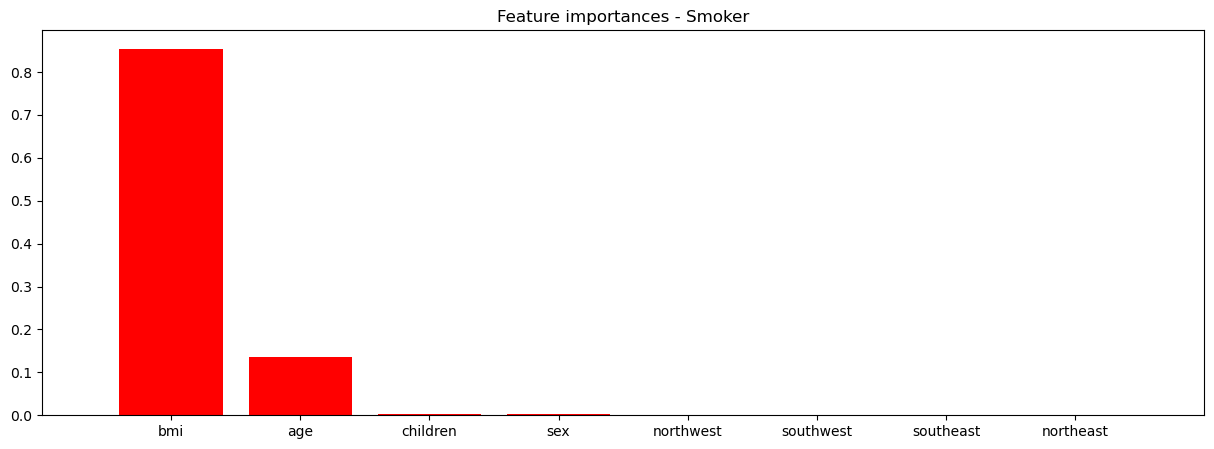

Feature ranking - Non Smoker:
1. feature age (0.827004)
2. feature children (0.081011)
3. feature bmi (0.047583)
4. feature sex (0.016749)
5. feature southwest (0.012232)
6. feature southeast (0.007101)
7. feature northwest (0.004719)
8. feature northeast (0.003601)


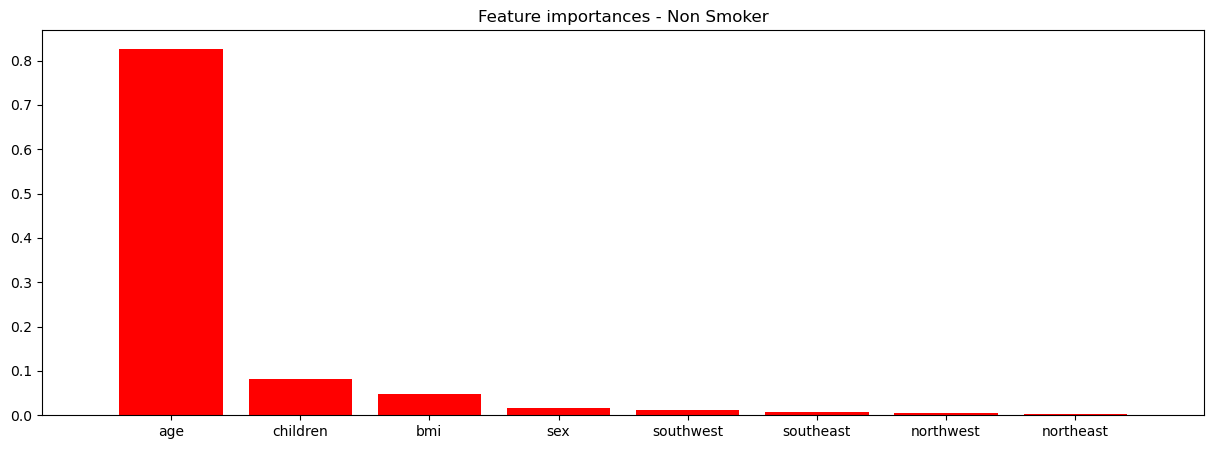

In [49]:
RF_smoker = RandomForestRegressor(max_samples=0.6, min_samples_leaf=5, min_samples_split=5, n_estimators=50)
RF_nonsmoker = RandomForestRegressor(max_samples=0.6, min_samples_leaf=5, min_samples_split=5, n_estimators=50)
RF_smoker.fit(X_smoker,y_smoker)
RF_nonsmoker.fit(X_nonsmoker,y_nonsmoker)
importances_smoker = RF_smoker.feature_importances_
importances_nonsmoker = RF_nonsmoker.feature_importances_
indices_smoker = np.argsort(importances_smoker)[::-1]
indices_nonsmoker = np.argsort(importances_nonsmoker)[::-1]

# Print the feature ranking
print("Feature ranking - Smoker:")

for f in range(X_smoker.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_smoker.columns[indices_smoker[f]], importances_smoker[indices_smoker[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15, 5))
plt.title("Feature importances - Smoker")
plt.bar(range(X_smoker.shape[1]), importances_smoker[indices_smoker],
        color="r", align="center")
plt.xticks(range(X_smoker.shape[1]), X_smoker.columns[indices_smoker])
plt.xlim([-1, X_smoker.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking - Non Smoker:")

for f in range(X_nonsmoker.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_nonsmoker.columns[indices_nonsmoker[f]], importances_nonsmoker[indices_nonsmoker[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15, 5))
plt.title("Feature importances - Non Smoker")
plt.bar(range(X_nonsmoker.shape[1]), importances_nonsmoker[indices_nonsmoker],
        color="r", align="center")
plt.xticks(range(X_nonsmoker.shape[1]), X_nonsmoker.columns[indices_nonsmoker])
plt.xlim([-1, X_nonsmoker.shape[1]])
plt.show()

Nous constatons que sur le modèle fumeurs, ce sont quasi exclusivement les variables `bmi` puis dans une moindre mesure `age` qui apportent de l'information.  

Sur le modèle non fumeurs, c'est la variable `age` qui apporte le plus d'information, puis dans une moindre mesure `children` et `bmi`. Les variables `sex` et `southwest` apportent de très légères informations.